In [10]:
# Libraries
from scipy.stats import norm, beta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import locale

In [11]:
# Load private loan PD values from CSV
private_pd_df = pd.read_csv('Private_PD.csv')
private_PD = private_pd_df['PD'].values

# Load business loan PD values from CSV
business_pd_df = pd.read_csv('Business_PD.csv')
business_PD = business_pd_df['Default Probability'].values

# Fixed parameters
n_simulations = 1000
n_assets = 500
rho_personal1 = 0.15
rho_business1 = 0.3
rho_personal2 = 0.2
rho_business2 = 0.4
rho_personal3 = 0.22
rho_business3 = 0.45
rho_personal4 = 0.3
rho_business4 = 0.5
rho_personal5 = 0.4
rho_business5 = 0.6
np.random.seed(0)

In [12]:
# Randomly assigning personal (0) and business (1) loans
loan_types1 = np.random.choice([0, 1], n_assets, p=[0.3, 0.7])  
loan_types2 = np.random.choice([0, 1], n_assets, p=[0.4, 0.6])  
loan_types3 = np.random.choice([0, 1], n_assets, p=[0.5, 0.5])  
loan_types4 = np.random.choice([0, 1], n_assets, p=[0.6, 0.4])  
loan_types5 = np.random.choice([0, 1], n_assets, p=[0.7, 0.3])  

# Separate PD values
personal_PD1 = np.random.choice(private_PD, np.sum(loan_types1 == 0), replace=True)
business_PD1 = np.random.choice(business_PD, np.sum(loan_types1 == 1), replace=True)
print(f"Assigned {np.sum(loan_types1 == 0)} PD values for personal and {np.sum(loan_types1 == 1)} for business loans.")

personal_PD2 = np.random.choice(private_PD, np.sum(loan_types2 == 0), replace=True)
business_PD2 = np.random.choice(business_PD, np.sum(loan_types2 == 1), replace=True)
print(f"Assigned {np.sum(loan_types2 == 0)} PD values for personal and {np.sum(loan_types2 == 1)} for business loans.")

personal_PD3 = np.random.choice(private_PD, np.sum(loan_types3 == 0), replace=True)
business_PD3 = np.random.choice(business_PD, np.sum(loan_types3 == 1), replace=True)
print(f"Assigned {np.sum(loan_types3 == 0)} PD values for personal and {np.sum(loan_types3 == 1)} for business loans.")

personal_PD4 = np.random.choice(private_PD, np.sum(loan_types4 == 0), replace=True)
business_PD4 = np.random.choice(business_PD, np.sum(loan_types4 == 1), replace=True)
print(f"Assigned {np.sum(loan_types4 == 0)} PD values for personal and {np.sum(loan_types4 == 1)} for business loans.")

personal_PD5 = np.random.choice(private_PD, np.sum(loan_types5 == 0), replace=True)
business_PD5 = np.random.choice(business_PD, np.sum(loan_types5 == 1), replace=True)
print(f"Assigned {np.sum(loan_types5 == 0)} PD values for personal and {np.sum(loan_types5 == 1)} for business loans.")

Assigned 162 PD values for personal and 338 for business loans.
Assigned 210 PD values for personal and 290 for business loans.
Assigned 241 PD values for personal and 259 for business loans.
Assigned 284 PD values for personal and 216 for business loans.
Assigned 353 PD values for personal and 147 for business loans.


In [13]:
# Initialize LGD
LGD_personal1 = np.ones(np.sum(loan_types1 == 0))
LGD_business1 = beta.rvs(8, 12, size=np.sum(loan_types1 == 1))

LGD_personal2 = np.ones(np.sum(loan_types2 == 0))
LGD_business2 = beta.rvs(8, 12, size=np.sum(loan_types2 == 1))

LGD_personal3 = np.ones(np.sum(loan_types3 == 0))
LGD_business3 = beta.rvs(8, 12, size=np.sum(loan_types3 == 1))

LGD_personal4 = np.ones(np.sum(loan_types4 == 0))
LGD_business4 = beta.rvs(8, 12, size=np.sum(loan_types4 == 1))

LGD_personal5 = np.ones(np.sum(loan_types5 == 0))
LGD_business5 = beta.rvs(8, 12, size=np.sum(loan_types5 == 1))

print("The personal loan probability1 of default is: {:.2%}".format(np.mean(personal_PD1)))
print("The business loan probability1 of default is: {:.2%} ".format(np.mean(business_PD1)))

print("The personal loan probability2 of default is: {:.2%}".format(np.mean(personal_PD2)))
print("The business loan probability2 of default is: {:.2%} ".format(np.mean(business_PD2)))

print("The personal loan probability3 of default is: {:.2%}".format(np.mean(personal_PD3)))
print("The business loan probability3 of default is: {:.2%} ".format(np.mean(business_PD3)))

print("The personal loan probability4 of default is: {:.2%}".format(np.mean(personal_PD4)))
print("The business loan probability4 of default is: {:.2%} ".format(np.mean(business_PD4)))

print("The personal loan probability5 of default is: {:.2%}".format(np.mean(personal_PD5)))
print("The business loan probability5 of default is: {:.2%} ".format(np.mean(business_PD5)))

loan_amounts_personal1 = np.zeros(np.sum(loan_types1 == 0))
loan_amounts_business1 = np.zeros(np.sum(loan_types1 == 1))

loan_amounts_personal2 = np.zeros(np.sum(loan_types2 == 0))
loan_amounts_business2 = np.zeros(np.sum(loan_types2 == 1))

loan_amounts_personal3 = np.zeros(np.sum(loan_types3 == 0))
loan_amounts_business3 = np.zeros(np.sum(loan_types3 == 1))

loan_amounts_personal4 = np.zeros(np.sum(loan_types4 == 0))
loan_amounts_business4 = np.zeros(np.sum(loan_types4 == 1))

loan_amounts_personal5 = np.zeros(np.sum(loan_types5 == 0))
loan_amounts_business5 = np.zeros(np.sum(loan_types5 == 1))

# Assign loan amounts and LGD based on PD and loan type
for i in range(len(personal_PD1)):
    if personal_PD1[i] < 0.25:
        loan_amounts_personal1[i] = 11500
    else:
        loan_amounts_personal1[i] = 0

for i in range(len(business_PD1)):
    if business_PD1[i] < 0.0001:
        loan_amounts_business1[i] = 600000
    elif business_PD1[i] < 0.0007:
        loan_amounts_business1[i] = 450000
    elif business_PD1[i] < 0.0019:
        loan_amounts_business1[i] = 300000
    elif business_PD1[i] < 0.0536:
        loan_amounts_business1[i] = 100000
    elif business_PD1[i] < 0.2523:
        loan_amounts_business1[i] = 25000
    else:
        loan_amounts_business1[i] = 0

        # Assign loan amounts and LGD based on PD and loan type
for i in range(len(personal_PD2)):
    if personal_PD2[i] < 0.25:
        loan_amounts_personal2[i] = 11500
    else:
        loan_amounts_personal2[i] = 0

for i in range(len(business_PD2)):
    if business_PD2[i] < 0.0001:
        loan_amounts_business2[i] = 600000
    elif business_PD2[i] < 0.0007:
        loan_amounts_business2[i] = 450000
    elif business_PD2[i] < 0.0019:
        loan_amounts_business2[i] = 300000
    elif business_PD2[i] < 0.0536:
        loan_amounts_business2[i] = 100000
    elif business_PD2[i] < 0.2523:
        loan_amounts_business2[i] = 25000
    else:
        loan_amounts_business2[i] = 0

        # Assign loan amounts and LGD based on PD and loan type
for i in range(len(personal_PD3)):
    if personal_PD3[i] < 0.25:
        loan_amounts_personal3[i] = 11500
    else:
        loan_amounts_personal3[i] = 0

for i in range(len(business_PD3)):
    if business_PD3[i] < 0.0001:
        loan_amounts_business3[i] = 600000
    elif business_PD3[i] < 0.0007:
        loan_amounts_business3[i] = 450000
    elif business_PD3[i] < 0.0019:
        loan_amounts_business3[i] = 300000
    elif business_PD3[i] < 0.0536:
        loan_amounts_business3[i] = 100000
    elif business_PD3[i] < 0.2523:
        loan_amounts_business3[i] = 25000
    else:
        loan_amounts_business3[i] = 0

        # Assign loan amounts and LGD based on PD and loan type
for i in range(len(personal_PD4)):
    if personal_PD4[i] < 0.25:
        loan_amounts_personal4[i] = 11500
    else:
        loan_amounts_personal4[i] = 0

for i in range(len(business_PD4)):
    if business_PD4[i] < 0.0001:
        loan_amounts_business4[i] = 600000
    elif business_PD4[i] < 0.0007:
        loan_amounts_business4[i] = 450000
    elif business_PD4[i] < 0.0019:
        loan_amounts_business4[i] = 300000
    elif business_PD4[i] < 0.0536:
        loan_amounts_business4[i] = 100000
    elif business_PD4[i] < 0.2523:
        loan_amounts_business4[i] = 25000
    else:
        loan_amounts_business4[i] = 0

        # Assign loan amounts and LGD based on PD and loan type
for i in range(len(personal_PD5)):
    if personal_PD5[i] < 0.25:
        loan_amounts_personal5[i] = 11500
    else:
        loan_amounts_personal5[i] = 0

for i in range(len(business_PD5)):
    if business_PD5[i] < 0.0001:
        loan_amounts_business5[i] = 600000
    elif business_PD5[i] < 0.0007:
        loan_amounts_business5[i] = 450000
    elif business_PD5[i] < 0.0019:
        loan_amounts_business5[i] = 300000
    elif business_PD5[i] < 0.0536:
        loan_amounts_business5[i] = 100000
    elif business_PD5[i] < 0.2523:
        loan_amounts_business5[i] = 25000
    else:
        loan_amounts_business5[i] = 0

The personal loan probability1 of default is: 2.19%
The business loan probability1 of default is: 7.63% 
The personal loan probability2 of default is: 2.67%
The business loan probability2 of default is: 5.11% 
The personal loan probability3 of default is: 2.41%
The business loan probability3 of default is: 6.93% 
The personal loan probability4 of default is: 2.58%
The business loan probability4 of default is: 9.53% 
The personal loan probability5 of default is: 2.61%
The business loan probability5 of default is: 9.66% 


In [14]:
# Losses
losses_personal11 = np.zeros(n_simulations)
losses_business11 = np.zeros(n_simulations)

# Vasicek parameters
Y = np.random.normal(0, 1, n_simulations)
Z = np.random.normal(0, 1, (n_simulations, n_assets))

# Loss simulation
for i in range(n_simulations):
    X_personal = (np.sqrt(rho_personal1**2) * Y[i]) + (np.sqrt(1 - rho_personal1**2) * Z[i][loan_types1 == 0])
    X_business = (np.sqrt(rho_business1**2) * Y[i]) + (np.sqrt(1 - rho_business1**2) * Z[i][loan_types1 == 1])

    default_events_personal = X_personal < [norm.ppf(pd) for pd in personal_PD1]
    default_events_business = X_business < [norm.ppf(pd) for pd in business_PD1]
    
    loss_personal = np.sum(default_events_personal * LGD_personal1 * loan_amounts_personal1)
    loss_business = np.sum(default_events_business * LGD_business1 * loan_amounts_business1)
    
    losses_personal11[i] = loss_personal
    losses_business11[i] = loss_business

    # Losses
losses_personal12 = np.zeros(n_simulations)
losses_business12 = np.zeros(n_simulations)

# Vasicek parameters
Y = np.random.normal(0, 1, n_simulations)
Z = np.random.normal(0, 1, (n_simulations, n_assets))

# Loss simulation
for i in range(n_simulations):
    X_personal = (np.sqrt(rho_personal1**2) * Y[i]) + (np.sqrt(1 - rho_personal1**2) * Z[i][loan_types2 == 0])
    X_business = (np.sqrt(rho_business1**2) * Y[i]) + (np.sqrt(1 - rho_business1**2) * Z[i][loan_types2 == 1])

    default_events_personal = X_personal < [norm.ppf(pd) for pd in personal_PD2]
    default_events_business = X_business < [norm.ppf(pd) for pd in business_PD2]
    
    loss_personal = np.sum(default_events_personal * LGD_personal2 * loan_amounts_personal2)
    loss_business = np.sum(default_events_business * LGD_business2 * loan_amounts_business2)
    
    losses_personal12[i] = loss_personal
    losses_business12[i] = loss_business

    # Losses
losses_personal13 = np.zeros(n_simulations)
losses_business13 = np.zeros(n_simulations)

# Vasicek parameters
Y = np.random.normal(0, 1, n_simulations)
Z = np.random.normal(0, 1, (n_simulations, n_assets))

# Loss simulation
for i in range(n_simulations):
    X_personal = (np.sqrt(rho_personal1**2) * Y[i]) + (np.sqrt(1 - rho_personal1**2) * Z[i][loan_types3 == 0])
    X_business = (np.sqrt(rho_business1**2) * Y[i]) + (np.sqrt(1 - rho_business1**2) * Z[i][loan_types3 == 1])

    default_events_personal = X_personal < [norm.ppf(pd) for pd in personal_PD3]
    default_events_business = X_business < [norm.ppf(pd) for pd in business_PD3]
    
    loss_personal = np.sum(default_events_personal * LGD_personal3 * loan_amounts_personal3)
    loss_business = np.sum(default_events_business * LGD_business3 * loan_amounts_business3)
    
    losses_personal13[i] = loss_personal
    losses_business13[i] = loss_business

    # Losses
losses_personal14 = np.zeros(n_simulations)
losses_business14 = np.zeros(n_simulations)

# Vasicek parameters
Y = np.random.normal(0, 1, n_simulations)
Z = np.random.normal(0, 1, (n_simulations, n_assets))

# Loss simulation
for i in range(n_simulations):
    X_personal = (np.sqrt(rho_personal1**2) * Y[i]) + (np.sqrt(1 - rho_personal1**2) * Z[i][loan_types4 == 0])
    X_business = (np.sqrt(rho_business1**2) * Y[i]) + (np.sqrt(1 - rho_business1**2) * Z[i][loan_types4 == 1])

    default_events_personal = X_personal < [norm.ppf(pd) for pd in personal_PD4]
    default_events_business = X_business < [norm.ppf(pd) for pd in business_PD4]
    
    loss_personal = np.sum(default_events_personal * LGD_personal4 * loan_amounts_personal4)
    loss_business = np.sum(default_events_business * LGD_business4 * loan_amounts_business4)
    
    losses_personal14[i] = loss_personal
    losses_business14[i] = loss_business

    # Losses
losses_personal15 = np.zeros(n_simulations)
losses_business15 = np.zeros(n_simulations)

# Vasicek parameters
Y = np.random.normal(0, 1, n_simulations)
Z = np.random.normal(0, 1, (n_simulations, n_assets))

# Loss simulation
for i in range(n_simulations):
    X_personal = (np.sqrt(rho_personal1**2) * Y[i]) + (np.sqrt(1 - rho_personal1**2) * Z[i][loan_types5 == 0])
    X_business = (np.sqrt(rho_business1**2) * Y[i]) + (np.sqrt(1 - rho_business1**2) * Z[i][loan_types5 == 1])

    default_events_personal = X_personal < [norm.ppf(pd) for pd in personal_PD5]
    default_events_business = X_business < [norm.ppf(pd) for pd in business_PD5]
    
    loss_personal = np.sum(default_events_personal * LGD_personal5 * loan_amounts_personal5)
    loss_business = np.sum(default_events_business * LGD_business5 * loan_amounts_business5)
    
    losses_personal15[i] = loss_personal
    losses_business15[i] = loss_business

In [15]:
# Losses
losses_personal21 = np.zeros(n_simulations)
losses_business21 = np.zeros(n_simulations)

# Vasicek parameters
Y = np.random.normal(0, 1, n_simulations)
Z = np.random.normal(0, 1, (n_simulations, n_assets))

# Loss simulation
for i in range(n_simulations):
    X_personal = (np.sqrt(rho_personal2**2) * Y[i]) + (np.sqrt(1 - rho_personal2**2) * Z[i][loan_types1 == 0])
    X_business = (np.sqrt(rho_business2**2) * Y[i]) + (np.sqrt(1 - rho_business2**2) * Z[i][loan_types1 == 1])

    default_events_personal = X_personal < [norm.ppf(pd) for pd in personal_PD1]
    default_events_business = X_business < [norm.ppf(pd) for pd in business_PD1]
    
    loss_personal = np.sum(default_events_personal * LGD_personal1 * loan_amounts_personal1)
    loss_business = np.sum(default_events_business * LGD_business1 * loan_amounts_business1)
    
    losses_personal21[i] = loss_personal
    losses_business21[i] = loss_business

    # Losses
losses_personal22 = np.zeros(n_simulations)
losses_business22 = np.zeros(n_simulations)

# Vasicek parameters
Y = np.random.normal(0, 1, n_simulations)
Z = np.random.normal(0, 1, (n_simulations, n_assets))

# Loss simulation
for i in range(n_simulations):
    X_personal = (np.sqrt(rho_personal2**2) * Y[i]) + (np.sqrt(1 - rho_personal2**2) * Z[i][loan_types2 == 0])
    X_business = (np.sqrt(rho_business2**2) * Y[i]) + (np.sqrt(1 - rho_business2**2) * Z[i][loan_types2 == 1])

    default_events_personal = X_personal < [norm.ppf(pd) for pd in personal_PD2]
    default_events_business = X_business < [norm.ppf(pd) for pd in business_PD2]
    
    loss_personal = np.sum(default_events_personal * LGD_personal2 * loan_amounts_personal2)
    loss_business = np.sum(default_events_business * LGD_business2 * loan_amounts_business2)
    
    losses_personal22[i] = loss_personal
    losses_business22[i] = loss_business

    # Losses
losses_personal23 = np.zeros(n_simulations)
losses_business23 = np.zeros(n_simulations)

# Vasicek parameters
Y = np.random.normal(0, 1, n_simulations)
Z = np.random.normal(0, 1, (n_simulations, n_assets))

# Loss simulation
for i in range(n_simulations):
    X_personal = (np.sqrt(rho_personal2**2) * Y[i]) + (np.sqrt(1 - rho_personal2**2) * Z[i][loan_types3 == 0])
    X_business = (np.sqrt(rho_business2**2) * Y[i]) + (np.sqrt(1 - rho_business2**2) * Z[i][loan_types3 == 1])

    default_events_personal = X_personal < [norm.ppf(pd) for pd in personal_PD3]
    default_events_business = X_business < [norm.ppf(pd) for pd in business_PD3]
    
    loss_personal = np.sum(default_events_personal * LGD_personal3 * loan_amounts_personal3)
    loss_business = np.sum(default_events_business * LGD_business3 * loan_amounts_business3)
    
    losses_personal23[i] = loss_personal
    losses_business23[i] = loss_business

    # Losses
losses_personal24 = np.zeros(n_simulations)
losses_business24 = np.zeros(n_simulations)

# Vasicek parameters
Y = np.random.normal(0, 1, n_simulations)
Z = np.random.normal(0, 1, (n_simulations, n_assets))

# Loss simulation
for i in range(n_simulations):
    X_personal = (np.sqrt(rho_personal2**2) * Y[i]) + (np.sqrt(1 - rho_personal2**2) * Z[i][loan_types4 == 0])
    X_business = (np.sqrt(rho_business2**2) * Y[i]) + (np.sqrt(1 - rho_business2**2) * Z[i][loan_types4 == 1])

    default_events_personal = X_personal < [norm.ppf(pd) for pd in personal_PD4]
    default_events_business = X_business < [norm.ppf(pd) for pd in business_PD4]
    
    loss_personal = np.sum(default_events_personal * LGD_personal4 * loan_amounts_personal4)
    loss_business = np.sum(default_events_business * LGD_business4 * loan_amounts_business4)
    
    losses_personal24[i] = loss_personal
    losses_business24[i] = loss_business

    # Losses
losses_personal25= np.zeros(n_simulations)
losses_business25 = np.zeros(n_simulations)

# Vasicek parameters
Y = np.random.normal(0, 1, n_simulations)
Z = np.random.normal(0, 1, (n_simulations, n_assets))

# Loss simulation
for i in range(n_simulations):
    X_personal = (np.sqrt(rho_personal2**2) * Y[i]) + (np.sqrt(1 - rho_personal2**2) * Z[i][loan_types5 == 0])
    X_business = (np.sqrt(rho_business2**2) * Y[i]) + (np.sqrt(1 - rho_business2**2) * Z[i][loan_types5 == 1])

    default_events_personal = X_personal < [norm.ppf(pd) for pd in personal_PD5]
    default_events_business = X_business < [norm.ppf(pd) for pd in business_PD5]
    
    loss_personal = np.sum(default_events_personal * LGD_personal5 * loan_amounts_personal5)
    loss_business = np.sum(default_events_business * LGD_business5 * loan_amounts_business5)
    
    losses_personal25[i] = loss_personal
    losses_business25[i] = loss_business

In [16]:
# Losses
losses_personal31 = np.zeros(n_simulations)
losses_business31 = np.zeros(n_simulations)

# Vasicek parameters
Y = np.random.normal(0, 1, n_simulations)
Z = np.random.normal(0, 1, (n_simulations, n_assets))

# Loss simulation
for i in range(n_simulations):
    X_personal = (np.sqrt(rho_personal3**2) * Y[i]) + (np.sqrt(1 - rho_personal3**2) * Z[i][loan_types1 == 0])
    X_business = (np.sqrt(rho_business3**2) * Y[i]) + (np.sqrt(1 - rho_business3**2) * Z[i][loan_types1 == 1])

    default_events_personal = X_personal < [norm.ppf(pd) for pd in personal_PD1]
    default_events_business = X_business < [norm.ppf(pd) for pd in business_PD1]
    
    loss_personal = np.sum(default_events_personal * LGD_personal1 * loan_amounts_personal1)
    loss_business = np.sum(default_events_business * LGD_business1 * loan_amounts_business1)
    
    losses_personal31[i] = loss_personal
    losses_business31[i] = loss_business

    # Losses
losses_personal32 = np.zeros(n_simulations)
losses_business32 = np.zeros(n_simulations)

# Vasicek parameters
Y = np.random.normal(0, 1, n_simulations)
Z = np.random.normal(0, 1, (n_simulations, n_assets))

# Loss simulation
for i in range(n_simulations):
    X_personal = (np.sqrt(rho_personal3**2) * Y[i]) + (np.sqrt(1 - rho_personal3**2) * Z[i][loan_types2 == 0])
    X_business = (np.sqrt(rho_business3**2) * Y[i]) + (np.sqrt(1 - rho_business3**2) * Z[i][loan_types2 == 1])

    default_events_personal = X_personal < [norm.ppf(pd) for pd in personal_PD2]
    default_events_business = X_business < [norm.ppf(pd) for pd in business_PD2]
    
    loss_personal = np.sum(default_events_personal * LGD_personal2 * loan_amounts_personal2)
    loss_business = np.sum(default_events_business * LGD_business2 * loan_amounts_business2)
    
    losses_personal32[i] = loss_personal
    losses_business32[i] = loss_business

    # Losses
losses_personal33 = np.zeros(n_simulations)
losses_business33 = np.zeros(n_simulations)

# Vasicek parameters
Y = np.random.normal(0, 1, n_simulations)
Z = np.random.normal(0, 1, (n_simulations, n_assets))

# Loss simulation
for i in range(n_simulations):
    X_personal = (np.sqrt(rho_personal3**2) * Y[i]) + (np.sqrt(1 - rho_personal3**2) * Z[i][loan_types3 == 0])
    X_business = (np.sqrt(rho_business3**2) * Y[i]) + (np.sqrt(1 - rho_business3**2) * Z[i][loan_types3 == 1])

    default_events_personal = X_personal < [norm.ppf(pd) for pd in personal_PD3]
    default_events_business = X_business < [norm.ppf(pd) for pd in business_PD3]
    
    loss_personal = np.sum(default_events_personal * LGD_personal3 * loan_amounts_personal3)
    loss_business = np.sum(default_events_business * LGD_business3 * loan_amounts_business3)
    
    losses_personal33[i] = loss_personal
    losses_business33[i] = loss_business

    # Losses
losses_personal34 = np.zeros(n_simulations)
losses_business34 = np.zeros(n_simulations)

# Vasicek parameters
Y = np.random.normal(0, 1, n_simulations)
Z = np.random.normal(0, 1, (n_simulations, n_assets))

# Loss simulation
for i in range(n_simulations):
    X_personal = (np.sqrt(rho_personal3**2) * Y[i]) + (np.sqrt(1 - rho_personal3**2) * Z[i][loan_types4 == 0])
    X_business = (np.sqrt(rho_business3**2) * Y[i]) + (np.sqrt(1 - rho_business3**2) * Z[i][loan_types4 == 1])

    default_events_personal = X_personal < [norm.ppf(pd) for pd in personal_PD4]
    default_events_business = X_business < [norm.ppf(pd) for pd in business_PD4]
    
    loss_personal = np.sum(default_events_personal * LGD_personal4 * loan_amounts_personal4)
    loss_business = np.sum(default_events_business * LGD_business4 * loan_amounts_business4)
    
    losses_personal34[i] = loss_personal
    losses_business34[i] = loss_business

    # Losses
losses_personal35 = np.zeros(n_simulations)
losses_business35 = np.zeros(n_simulations)

# Vasicek parameters
Y = np.random.normal(0, 1, n_simulations)
Z = np.random.normal(0, 1, (n_simulations, n_assets))

# Loss simulation
for i in range(n_simulations):
    X_personal = (np.sqrt(rho_personal3**2) * Y[i]) + (np.sqrt(1 - rho_personal3**2) * Z[i][loan_types5 == 0])
    X_business = (np.sqrt(rho_business3**2) * Y[i]) + (np.sqrt(1 - rho_business3**2) * Z[i][loan_types5 == 1])

    default_events_personal = X_personal < [norm.ppf(pd) for pd in personal_PD5]
    default_events_business = X_business < [norm.ppf(pd) for pd in business_PD5]
    
    loss_personal = np.sum(default_events_personal * LGD_personal5 * loan_amounts_personal5)
    loss_business = np.sum(default_events_business * LGD_business5 * loan_amounts_business5)
    
    losses_personal35[i] = loss_personal
    losses_business35[i] = loss_business

In [17]:
# Losses
losses_personal41 = np.zeros(n_simulations)
losses_business41 = np.zeros(n_simulations)

# Vasicek parameters
Y = np.random.normal(0, 1, n_simulations)
Z = np.random.normal(0, 1, (n_simulations, n_assets))

# Loss simulation
for i in range(n_simulations):
    X_personal = (np.sqrt(rho_personal4**2) * Y[i]) + (np.sqrt(1 - rho_personal4**2) * Z[i][loan_types1 == 0])
    X_business = (np.sqrt(rho_business4**2) * Y[i]) + (np.sqrt(1 - rho_business4**2) * Z[i][loan_types1 == 1])

    default_events_personal = X_personal < [norm.ppf(pd) for pd in personal_PD1]
    default_events_business = X_business < [norm.ppf(pd) for pd in business_PD1]
    
    loss_personal = np.sum(default_events_personal * LGD_personal1 * loan_amounts_personal1)
    loss_business = np.sum(default_events_business * LGD_business1 * loan_amounts_business1)
    
    losses_personal41[i] = loss_personal
    losses_business41[i] = loss_business

    # Losses
losses_personal42 = np.zeros(n_simulations)
losses_business42 = np.zeros(n_simulations)

# Vasicek parameters
Y = np.random.normal(0, 1, n_simulations)
Z = np.random.normal(0, 1, (n_simulations, n_assets))

# Loss simulation
for i in range(n_simulations):
    X_personal = (np.sqrt(rho_personal4**2) * Y[i]) + (np.sqrt(1 - rho_personal4**2) * Z[i][loan_types2 == 0])
    X_business = (np.sqrt(rho_business4**2) * Y[i]) + (np.sqrt(1 - rho_business4**2) * Z[i][loan_types2 == 1])

    default_events_personal = X_personal < [norm.ppf(pd) for pd in personal_PD2]
    default_events_business = X_business < [norm.ppf(pd) for pd in business_PD2]
    
    loss_personal = np.sum(default_events_personal * LGD_personal2 * loan_amounts_personal2)
    loss_business = np.sum(default_events_business * LGD_business2 * loan_amounts_business2)
    
    losses_personal42[i] = loss_personal
    losses_business42[i] = loss_business

    # Losses
losses_personal43 = np.zeros(n_simulations)
losses_business43 = np.zeros(n_simulations)

# Vasicek parameters
Y = np.random.normal(0, 1, n_simulations)
Z = np.random.normal(0, 1, (n_simulations, n_assets))

# Loss simulation
for i in range(n_simulations):
    X_personal = (np.sqrt(rho_personal4**2) * Y[i]) + (np.sqrt(1 - rho_personal4**2) * Z[i][loan_types3 == 0])
    X_business = (np.sqrt(rho_business4**2) * Y[i]) + (np.sqrt(1 - rho_business4**2) * Z[i][loan_types3 == 1])

    default_events_personal = X_personal < [norm.ppf(pd) for pd in personal_PD3]
    default_events_business = X_business < [norm.ppf(pd) for pd in business_PD3]
    
    loss_personal = np.sum(default_events_personal * LGD_personal3 * loan_amounts_personal3)
    loss_business = np.sum(default_events_business * LGD_business3 * loan_amounts_business3)
    
    losses_personal43[i] = loss_personal
    losses_business43[i] = loss_business

    # Losses
losses_personal44 = np.zeros(n_simulations)
losses_business44 = np.zeros(n_simulations)

# Vasicek parameters
Y = np.random.normal(0, 1, n_simulations)
Z = np.random.normal(0, 1, (n_simulations, n_assets))

# Loss simulation
for i in range(n_simulations):
    X_personal = (np.sqrt(rho_personal4**2) * Y[i]) + (np.sqrt(1 - rho_personal4**2) * Z[i][loan_types4 == 0])
    X_business = (np.sqrt(rho_business4**2) * Y[i]) + (np.sqrt(1 - rho_business4**2) * Z[i][loan_types4 == 1])

    default_events_personal = X_personal < [norm.ppf(pd) for pd in personal_PD4]
    default_events_business = X_business < [norm.ppf(pd) for pd in business_PD4]
    
    loss_personal = np.sum(default_events_personal * LGD_personal4 * loan_amounts_personal4)
    loss_business = np.sum(default_events_business * LGD_business4 * loan_amounts_business4)
    
    losses_personal44[i] = loss_personal
    losses_business44[i] = loss_business

    # Losses
losses_personal45 = np.zeros(n_simulations)
losses_business45 = np.zeros(n_simulations)

# Vasicek parameters
Y = np.random.normal(0, 1, n_simulations)
Z = np.random.normal(0, 1, (n_simulations, n_assets))

# Loss simulation
for i in range(n_simulations):
    X_personal = (np.sqrt(rho_personal4**2) * Y[i]) + (np.sqrt(1 - rho_personal4**2) * Z[i][loan_types5 == 0])
    X_business = (np.sqrt(rho_business4**2) * Y[i]) + (np.sqrt(1 - rho_business4**2) * Z[i][loan_types5 == 1])

    default_events_personal = X_personal < [norm.ppf(pd) for pd in personal_PD5]
    default_events_business = X_business < [norm.ppf(pd) for pd in business_PD5]
    
    loss_personal = np.sum(default_events_personal * LGD_personal5 * loan_amounts_personal5)
    loss_business = np.sum(default_events_business * LGD_business5 * loan_amounts_business5)
    
    losses_personal45[i] = loss_personal
    losses_business45[i] = loss_business

In [18]:
# Losses
losses_personal51 = np.zeros(n_simulations)
losses_business51 = np.zeros(n_simulations)

# Vasicek parameters
Y = np.random.normal(0, 1, n_simulations)
Z = np.random.normal(0, 1, (n_simulations, n_assets))

# Loss simulation
for i in range(n_simulations):
    X_personal = (np.sqrt(rho_personal5**2) * Y[i]) + (np.sqrt(1 - rho_personal5**2) * Z[i][loan_types1 == 0])
    X_business = (np.sqrt(rho_business5**2) * Y[i]) + (np.sqrt(1 - rho_business5**2) * Z[i][loan_types1 == 1])

    default_events_personal = X_personal < [norm.ppf(pd) for pd in personal_PD1]
    default_events_business = X_business < [norm.ppf(pd) for pd in business_PD1]
    
    loss_personal = np.sum(default_events_personal * LGD_personal1 * loan_amounts_personal1)
    loss_business = np.sum(default_events_business * LGD_business1 * loan_amounts_business1)
    
    losses_personal51[i] = loss_personal
    losses_business51[i] = loss_business

    # Losses
losses_personal52 = np.zeros(n_simulations)
losses_business52 = np.zeros(n_simulations)

# Vasicek parameters
Y = np.random.normal(0, 1, n_simulations)
Z = np.random.normal(0, 1, (n_simulations, n_assets))

# Loss simulation
for i in range(n_simulations):
    X_personal = (np.sqrt(rho_personal5**2) * Y[i]) + (np.sqrt(1 - rho_personal5**2) * Z[i][loan_types2 == 0])
    X_business = (np.sqrt(rho_business5**2) * Y[i]) + (np.sqrt(1 - rho_business5**2) * Z[i][loan_types2 == 1])

    default_events_personal = X_personal < [norm.ppf(pd) for pd in personal_PD2]
    default_events_business = X_business < [norm.ppf(pd) for pd in business_PD2]
    
    loss_personal = np.sum(default_events_personal * LGD_personal2 * loan_amounts_personal2)
    loss_business = np.sum(default_events_business * LGD_business2 * loan_amounts_business2)
    
    losses_personal52[i] = loss_personal
    losses_business52[i] = loss_business

    # Losses
losses_personal53 = np.zeros(n_simulations)
losses_business53 = np.zeros(n_simulations)

# Vasicek parameters
Y = np.random.normal(0, 1, n_simulations)
Z = np.random.normal(0, 1, (n_simulations, n_assets))

# Loss simulation
for i in range(n_simulations):
    X_personal = (np.sqrt(rho_personal5**2) * Y[i]) + (np.sqrt(1 - rho_personal5**2) * Z[i][loan_types3 == 0])
    X_business = (np.sqrt(rho_business5**2) * Y[i]) + (np.sqrt(1 - rho_business5**2) * Z[i][loan_types3 == 1])

    default_events_personal = X_personal < [norm.ppf(pd) for pd in personal_PD3]
    default_events_business = X_business < [norm.ppf(pd) for pd in business_PD3]
    
    loss_personal = np.sum(default_events_personal * LGD_personal3 * loan_amounts_personal3)
    loss_business = np.sum(default_events_business * LGD_business3 * loan_amounts_business3)
    
    losses_personal53[i] = loss_personal
    losses_business53[i] = loss_business

    # Losses
losses_personal54 = np.zeros(n_simulations)
losses_business54 = np.zeros(n_simulations)

# Vasicek parameters
Y = np.random.normal(0, 1, n_simulations)
Z = np.random.normal(0, 1, (n_simulations, n_assets))

# Loss simulation
for i in range(n_simulations):
    X_personal = (np.sqrt(rho_personal5**2) * Y[i]) + (np.sqrt(1 - rho_personal5**2) * Z[i][loan_types4 == 0])
    X_business = (np.sqrt(rho_business5**2) * Y[i]) + (np.sqrt(1 - rho_business5**2) * Z[i][loan_types4 == 1])

    default_events_personal = X_personal < [norm.ppf(pd) for pd in personal_PD4]
    default_events_business = X_business < [norm.ppf(pd) for pd in business_PD4]
    
    loss_personal = np.sum(default_events_personal * LGD_personal4 * loan_amounts_personal4)
    loss_business = np.sum(default_events_business * LGD_business4 * loan_amounts_business4)
    
    losses_personal54[i] = loss_personal
    losses_business54[i] = loss_business

    # Losses
losses_personal55 = np.zeros(n_simulations)
losses_business55 = np.zeros(n_simulations)

# Vasicek parameters
Y = np.random.normal(0, 1, n_simulations)
Z = np.random.normal(0, 1, (n_simulations, n_assets))

# Loss simulation
for i in range(n_simulations):
    X_personal = (np.sqrt(rho_personal5**2) * Y[i]) + (np.sqrt(1 - rho_personal5**2) * Z[i][loan_types5 == 0])
    X_business = (np.sqrt(rho_business5**2) * Y[i]) + (np.sqrt(1 - rho_business5**2) * Z[i][loan_types5 == 1])

    default_events_personal = X_personal < [norm.ppf(pd) for pd in personal_PD5]
    default_events_business = X_business < [norm.ppf(pd) for pd in business_PD5]
    
    loss_personal = np.sum(default_events_personal * LGD_personal5 * loan_amounts_personal5)
    loss_business = np.sum(default_events_business * LGD_business5 * loan_amounts_business5)
    
    losses_personal55[i] = loss_personal
    losses_business55[i] = loss_business

In [19]:
# Combine losses for calculations
total_losses11 = losses_personal11 + losses_business11
total_losses21 = losses_personal21 + losses_business21
total_losses31 = losses_personal31 + losses_business31
total_losses41 = losses_personal41 + losses_business41
total_losses51 = losses_personal51 + losses_business51

total_losses12 = losses_personal12 + losses_business12
total_losses22 = losses_personal22 + losses_business22
total_losses32 = losses_personal32 + losses_business32
total_losses42 = losses_personal42 + losses_business42
total_losses52 = losses_personal52 + losses_business52

total_losses13 = losses_personal13 + losses_business13
total_losses23 = losses_personal23 + losses_business23
total_losses33 = losses_personal33 + losses_business33
total_losses43 = losses_personal43 + losses_business43
total_losses53 = losses_personal53 + losses_business53

total_losses14 = losses_personal14 + losses_business14
total_losses24 = losses_personal24 + losses_business24
total_losses34 = losses_personal34 + losses_business34
total_losses44 = losses_personal44 + losses_business44
total_losses54 = losses_personal54 + losses_business54

total_losses15 = losses_personal15 + losses_business15
total_losses25 = losses_personal25 + losses_business25
total_losses35 = losses_personal35 + losses_business35
total_losses45 = losses_personal45 + losses_business45
total_losses55 = losses_personal55 + losses_business55

# Set locale to use dot as thousands separator and comma as decimal separator
locale.setlocale(locale.LC_ALL, 'en_de.UTF-8')

# Portfolio Value
PL1 = np.sum(loan_amounts_personal1)
BL1 = np.sum(loan_amounts_business1)
PV1 = PL1 + BL1
print(f"Portfolio Value1 (PV): {locale.format_string('%.2f', PV1, grouping=True)}€")
print(f"Personal Loans1: {locale.format_string('%.2f', PL1, grouping=True)}€")
print(f"Business Loans1: {locale.format_string('%.2f', BL1, grouping=True)}€")

PL2 = np.sum(loan_amounts_personal2)
BL2 = np.sum(loan_amounts_business2)
PV2 = PL2 + BL2
print(f"Portfolio Value2 (PV): {locale.format_string('%.2f', PV2, grouping=True)}€")
print(f"Personal Loans2: {locale.format_string('%.2f', PL2, grouping=True)}€")
print(f"Business Loans2: {locale.format_string('%.2f', BL2, grouping=True)}€")

PL3 = np.sum(loan_amounts_personal3)
BL3 = np.sum(loan_amounts_business3)
PV3 = PL3 + BL3
print(f"Portfolio Value3 (PV): {locale.format_string('%.2f', PV3, grouping=True)}€")
print(f"Personal Loans3: {locale.format_string('%.2f', PL3, grouping=True)}€")
print(f"Business Loans3: {locale.format_string('%.2f', BL3, grouping=True)}€")

PL4 = np.sum(loan_amounts_personal4)
BL4 = np.sum(loan_amounts_business4)
PV4 = PL4 + BL4
print(f"Portfolio Value4 (PV): {locale.format_string('%.2f', PV4, grouping=True)}€")
print(f"Personal Loans4: {locale.format_string('%.2f', PL4, grouping=True)}€")
print(f"Business Loans4: {locale.format_string('%.2f', BL4, grouping=True)}€")

PL5 = np.sum(loan_amounts_personal5)
BL5 = np.sum(loan_amounts_business5)
PV5 = PL5 + BL5
print(f"Portfolio Value5 (PV): {locale.format_string('%.2f', PV5, grouping=True)}€")
print(f"Personal Loans5: {locale.format_string('%.2f', PL5, grouping=True)}€")
print(f"Business Loans5: {locale.format_string('%.2f', BL5, grouping=True)}€")

# Expected Loss (EL)
EL11 = np.mean(total_losses11)
print(f"Expected Loss (EL11): {locale.format_string('%.2f', EL11, grouping=True)}€ {np.round(EL11/PV1*100,2)}%")

# Expected Loss (EL)
EL21 = np.mean(total_losses21)
print(f"Expected Loss (EL21): {locale.format_string('%.2f', EL21, grouping=True)}€ {np.round(EL21/PV1*100,2)}%")

# Expected Loss (EL)
EL31 = np.mean(total_losses31)
print(f"Expected Loss (EL31): {locale.format_string('%.2f', EL31, grouping=True)}€ {np.round(EL31/PV1*100,2)}%")

# Expected Loss (EL)
EL41 = np.mean(total_losses41)
print(f"Expected Loss (EL41): {locale.format_string('%.2f', EL41, grouping=True)}€ {np.round(EL41/PV1*100,2)}%")

# Expected Loss (EL)
EL51 = np.mean(total_losses51)
print(f"Expected Loss (EL51): {locale.format_string('%.2f', EL51, grouping=True)}€ {np.round(EL51/PV1*100,2)}%")

# Unexpected Loss (UL)
UL11 = np.std(total_losses11)+EL11
print(f"Unexpected Loss (UL11): {locale.format_string('%.2f', UL11, grouping=True)}€ {np.round(UL11/PV1*100,2)}%")

# Unexpected Loss (UL)
UL21 = np.std(total_losses21)+EL21
print(f"Unexpected Loss (UL21): {locale.format_string('%.2f', UL21, grouping=True)}€ {np.round(UL21/PV1*100,2)}%")

# Unexpected Loss (UL)
UL31 = np.std(total_losses31)+EL31
print(f"Unexpected Loss (UL31): {locale.format_string('%.2f', UL31, grouping=True)}€ {np.round(UL31/PV1*100,2)}%")

# Unexpected Loss (UL)
UL41 = np.std(total_losses41)+EL41
print(f"Unexpected Loss (UL41): {locale.format_string('%.2f', UL41, grouping=True)}€ {np.round(UL41/PV1*100,2)}%")

# Unexpected Loss (UL)
UL51 = np.std(total_losses51)+EL51
print(f"Unexpected Loss (UL51): {locale.format_string('%.2f', UL51, grouping=True)}€ {np.round(UL51/PV1*100,2)}%")

# Value at Risk (VaR) 99%
VaR_9911 = np.percentile(total_losses11, 99)
print(f"Value at Risk (VaR11) 99%: {locale.format_string('%.2f', VaR_9911, grouping=True)}€ {np.round(VaR_9911/PV1*100,2)}%")

# Value at Risk (VaR) 99%
VaR_9921 = np.percentile(total_losses21, 99)
print(f"Value at Risk (VaR21) 99%: {locale.format_string('%.2f', VaR_9921, grouping=True)}€ {np.round(VaR_9921/PV1*100,2)}%")

# Value at Risk (VaR) 99%
VaR_9931 = np.percentile(total_losses31, 99)
print(f"Value at Risk (VaR31) 99%: {locale.format_string('%.2f', VaR_9931, grouping=True)}€ {np.round(VaR_9931/PV1*100,2)}%")

# Value at Risk (VaR) 99%
VaR_9941 = np.percentile(total_losses41, 99)
print(f"Value at Risk (VaR41) 99%: {locale.format_string('%.2f', VaR_9941, grouping=True)}€ {np.round(VaR_9941/PV1*100,2)}%")

# Value at Risk (VaR) 99%
VaR_9951 = np.percentile(total_losses51, 99)
print(f"Value at Risk (VaR51) 99%: {locale.format_string('%.2f', VaR_9951, grouping=True)}€ {np.round(VaR_9951/PV1*100,2)}%")

# Value at Risk (VaR) 95%
VaR_9511 = np.percentile(total_losses11, 95)
print(f"Value at Risk (VaR11) 95%: {locale.format_string('%.2f', VaR_9511, grouping=True)}€ {np.round(VaR_9511/PV1*100,2)}%")

# Value at Risk (VaR) 95%
VaR_9521 = np.percentile(total_losses21, 95)
print(f"Value at Risk (VaR21) 95%: {locale.format_string('%.2f', VaR_9521, grouping=True)}€ {np.round(VaR_9521/PV1*100,2)}%")

# Value at Risk (VaR) 95%
VaR_9531 = np.percentile(total_losses31, 95)
print(f"Value at Risk (VaR31) 95%: {locale.format_string('%.2f', VaR_9531, grouping=True)}€ {np.round(VaR_9531/PV1*100,2)}%")

# Value at Risk (VaR) 95%
VaR_9541 = np.percentile(total_losses41, 95)
print(f"Value at Risk (VaR41) 95%: {locale.format_string('%.2f', VaR_9541, grouping=True)}€ {np.round(VaR_9541/PV1*100,2)}%")

# Value at Risk (VaR) 95%
VaR_9551 = np.percentile(total_losses51, 95)
print(f"Value at Risk (VaR51) 95%: {locale.format_string('%.2f', VaR_9551, grouping=True)}€ {np.round(VaR_9551/PV1*100,2)}%")

# Expected Loss (EL)
EL12 = np.mean(total_losses12)
print(f"Expected Loss (EL21): {locale.format_string('%.2f', EL12, grouping=True)}€ {np.round(EL12/PV2*100,2)}%")

# Expected Loss (EL)
EL22 = np.mean(total_losses22)
print(f"Expected Loss (EL22): {locale.format_string('%.2f', EL22, grouping=True)}€ {np.round(EL22/PV2*100,2)}%")

# Expected Loss (EL)
EL32 = np.mean(total_losses32)
print(f"Expected Loss (EL23): {locale.format_string('%.2f', EL32, grouping=True)}€ {np.round(EL32/PV2*100,2)}%")

# Expected Loss (EL)
EL42 = np.mean(total_losses42)
print(f"Expected Loss (EL24): {locale.format_string('%.2f', EL42, grouping=True)}€ {np.round(EL42/PV2*100,2)}%")

# Expected Loss (EL)
EL52 = np.mean(total_losses52)
print(f"Expected Loss (EL25): {locale.format_string('%.2f', EL52, grouping=True)}€ {np.round(EL52/PV2*100,2)}%")

# Unexpected Loss (UL)
UL12 = np.std(total_losses12)+EL12
print(f"Unexpected Loss (UL21): {locale.format_string('%.2f', UL12, grouping=True)}€ {np.round(UL12/PV2*100,2)}%")

# Unexpected Loss (UL)
UL22 = np.std(total_losses22)+EL22
print(f"Unexpected Loss (UL22): {locale.format_string('%.2f', UL22, grouping=True)}€ {np.round(UL22/PV2*100,2)}%")

# Unexpected Loss (UL)
UL32 = np.std(total_losses32)+EL32
print(f"Unexpected Loss (UL23): {locale.format_string('%.2f', UL32, grouping=True)}€ {np.round(UL32/PV2*100,2)}%")

# Unexpected Loss (UL)
UL42 = np.std(total_losses42)+EL42
print(f"Unexpected Loss (UL24): {locale.format_string('%.2f', UL42, grouping=True)}€ {np.round(UL42/PV2*100,2)}%")

# Unexpected Loss (UL)
UL52 = np.std(total_losses52)+EL52
print(f"Unexpected Loss (UL25): {locale.format_string('%.2f', UL52, grouping=True)}€ {np.round(UL52/PV2*100,2)}%")

# Value at Risk (VaR) 99%
VaR_9912 = np.percentile(total_losses12, 99)
print(f"Value at Risk (VaR21) 99%: {locale.format_string('%.2f', VaR_9912, grouping=True)}€ {np.round(VaR_9912/PV2*100,2)}%")

# Value at Risk (VaR) 99%
VaR_9922 = np.percentile(total_losses22, 99)
print(f"Value at Risk (VaR22) 99%: {locale.format_string('%.2f', VaR_9922, grouping=True)}€ {np.round(VaR_9922/PV2*100,2)}%")

# Value at Risk (VaR) 99%
VaR_9932 = np.percentile(total_losses32, 99)
print(f"Value at Risk (VaR23) 99%: {locale.format_string('%.2f', VaR_9932, grouping=True)}€ {np.round(VaR_9932/PV2*100,2)}%")

# Value at Risk (VaR) 99%
VaR_9942 = np.percentile(total_losses42, 99)
print(f"Value at Risk (VaR24) 99%: {locale.format_string('%.2f', VaR_9942, grouping=True)}€ {np.round(VaR_9942/PV2*100,2)}%")

# Value at Risk (VaR) 99%
VaR_9952 = np.percentile(total_losses52, 99)
print(f"Value at Risk (VaR25) 99%: {locale.format_string('%.2f', VaR_9952, grouping=True)}€ {np.round(VaR_9952/PV2*100,2)}%")

# Value at Risk (VaR) 95%
VaR_9512 = np.percentile(total_losses12, 95)
print(f"Value at Risk (VaR21) 95%: {locale.format_string('%.2f', VaR_9512, grouping=True)}€ {np.round(VaR_9512/PV2*100,2)}%")

# Value at Risk (VaR) 95%
VaR_9522 = np.percentile(total_losses22, 95)
print(f"Value at Risk (VaR22) 95%: {locale.format_string('%.2f', VaR_9522, grouping=True)}€ {np.round(VaR_9522/PV2*100,2)}%")

# Value at Risk (VaR) 95%
VaR_9532 = np.percentile(total_losses32, 95)
print(f"Value at Risk (VaR23 95%: {locale.format_string('%.2f', VaR_9532, grouping=True)}€ {np.round(VaR_9532/PV2*100,2)}%")

# Value at Risk (VaR) 95%
VaR_9542 = np.percentile(total_losses42, 95)
print(f"Value at Risk (VaR24) 95%: {locale.format_string('%.2f', VaR_9542, grouping=True)}€ {np.round(VaR_9542/PV2*100,2)}%")

# Value at Risk (VaR) 95%
VaR_9552 = np.percentile(total_losses52, 95)
print(f"Value at Risk (VaR25) 95%: {locale.format_string('%.2f', VaR_9552, grouping=True)}€ {np.round(VaR_9552/PV2*100,2)}%")

# Expected Loss (EL)
EL13 = np.mean(total_losses13)
print(f"Expected Loss (EL31): {locale.format_string('%.2f', EL13, grouping=True)}€ {np.round(EL13/PV3*100,2)}%")

# Expected Loss (EL)
EL23 = np.mean(total_losses23)
print(f"Expected Loss (EL32): {locale.format_string('%.2f', EL23, grouping=True)}€ {np.round(EL23/PV3*100,2)}%")

# Expected Loss (EL)
EL33 = np.mean(total_losses33)
print(f"Expected Loss (EL33): {locale.format_string('%.2f', EL33, grouping=True)}€ {np.round(EL33/PV3*100,2)}%")

# Expected Loss (EL)
EL43 = np.mean(total_losses43)
print(f"Expected Loss (EL34): {locale.format_string('%.2f', EL43, grouping=True)}€ {np.round(EL43/PV3*100,2)}%")

# Expected Loss (EL)
EL53 = np.mean(total_losses53)
print(f"Expected Loss (EL35): {locale.format_string('%.2f', EL53, grouping=True)}€ {np.round(EL53/PV3*100,2)}%")

# Unexpected Loss (UL)
UL13 = np.std(total_losses13)+EL13
print(f"Unexpected Loss (UL31): {locale.format_string('%.2f', UL13, grouping=True)}€ {np.round(UL13/PV3*100,2)}%")

# Unexpected Loss (UL)
UL23 = np.std(total_losses23)+EL23
print(f"Unexpected Loss (UL32): {locale.format_string('%.2f', UL23, grouping=True)}€ {np.round(UL23/PV3*100,2)}%")

# Unexpected Loss (UL)
UL33 = np.std(total_losses33)+EL33
print(f"Unexpected Loss (UL33): {locale.format_string('%.2f', UL33, grouping=True)}€ {np.round(UL33/PV3*100,2)}%")

# Unexpected Loss (UL)
UL43 = np.std(total_losses43)+EL43
print(f"Unexpected Loss (UL34): {locale.format_string('%.2f', UL43, grouping=True)}€ {np.round(UL43/PV3*100,2)}%")

# Unexpected Loss (UL)
UL53 = np.std(total_losses53)+EL53
print(f"Unexpected Loss (UL35): {locale.format_string('%.2f', UL53, grouping=True)}€ {np.round(UL53/PV3*100,2)}%")

# Value at Risk (VaR) 99%
VaR_9913 = np.percentile(total_losses13, 99)
print(f"Value at Risk (VaR31) 99%: {locale.format_string('%.2f', VaR_9913, grouping=True)}€ {np.round(VaR_9913/PV3*100,2)}%")

# Value at Risk (VaR) 99%
VaR_9923 = np.percentile(total_losses23, 99)
print(f"Value at Risk (VaR32) 99%: {locale.format_string('%.2f', VaR_9923, grouping=True)}€ {np.round(VaR_9923/PV3*100,2)}%")

# Value at Risk (VaR) 99%
VaR_9933 = np.percentile(total_losses33, 99)
print(f"Value at Risk (VaR33) 99%: {locale.format_string('%.2f', VaR_9933, grouping=True)}€ {np.round(VaR_9933/PV3*100,2)}%")

# Value at Risk (VaR) 99%
VaR_9943 = np.percentile(total_losses43, 99)
print(f"Value at Risk (VaR34) 99%: {locale.format_string('%.2f', VaR_9943, grouping=True)}€ {np.round(VaR_9943/PV3*100,2)}%")

# Value at Risk (VaR) 99%
VaR_9953 = np.percentile(total_losses53, 99)
print(f"Value at Risk (VaR35) 99%: {locale.format_string('%.2f', VaR_9953, grouping=True)}€ {np.round(VaR_9953/PV3*100,2)}%")

# Value at Risk (VaR) 95%
VaR_9513 = np.percentile(total_losses13, 95)
print(f"Value at Risk (VaR31) 95%: {locale.format_string('%.2f', VaR_9513, grouping=True)}€ {np.round(VaR_9513/PV3*100,2)}%")

# Value at Risk (VaR) 95%
VaR_9523 = np.percentile(total_losses23, 95)
print(f"Value at Risk (VaR32) 95%: {locale.format_string('%.2f', VaR_9523, grouping=True)}€ {np.round(VaR_9523/PV3*100,2)}%")

# Value at Risk (VaR) 95%
VaR_9533 = np.percentile(total_losses33, 95)
print(f"Value at Risk (VaR33) 95%: {locale.format_string('%.2f', VaR_9533, grouping=True)}€ {np.round(VaR_9533/PV3*100,2)}%")

# Value at Risk (VaR) 95%
VaR_9543 = np.percentile(total_losses43, 95)
print(f"Value at Risk (VaR34) 95%: {locale.format_string('%.2f', VaR_9543, grouping=True)}€ {np.round(VaR_9543/PV3*100,2)}%")

# Value at Risk (VaR) 95%
VaR_9553 = np.percentile(total_losses53, 95)
print(f"Value at Risk (VaR35) 95%: {locale.format_string('%.2f', VaR_9553, grouping=True)}€ {np.round(VaR_9553/PV3*100,2)}%")

# Expected Loss (EL)
EL14 = np.mean(total_losses14)
print(f"Expected Loss (EL41): {locale.format_string('%.2f', EL14, grouping=True)}€ {np.round(EL14/PV4*100,2)}%")

# Expected Loss (EL)
EL24 = np.mean(total_losses24)
print(f"Expected Loss (EL42): {locale.format_string('%.2f', EL24, grouping=True)}€ {np.round(EL24/PV4*100,2)}%")

# Expected Loss (EL)
EL34 = np.mean(total_losses34)
print(f"Expected Loss (EL43): {locale.format_string('%.2f', EL34, grouping=True)}€ {np.round(EL34/PV4*100,2)}%")

# Expected Loss (EL)
EL44 = np.mean(total_losses44)
print(f"Expected Loss (EL44): {locale.format_string('%.2f', EL44, grouping=True)}€ {np.round(EL44/PV4*100,2)}%")

# Expected Loss (EL)
EL54 = np.mean(total_losses54)
print(f"Expected Loss (EL45): {locale.format_string('%.2f', EL54, grouping=True)}€ {np.round(EL54/PV4*100,2)}%")

# Unexpected Loss (UL)
UL14 = np.std(total_losses14)+EL14
print(f"Unexpected Loss (UL41): {locale.format_string('%.2f', UL14, grouping=True)}€ {np.round(UL14/PV4*100,2)}%")

# Unexpected Loss (UL)
UL24 = np.std(total_losses24)+EL24
print(f"Unexpected Loss (UL42): {locale.format_string('%.2f', UL24, grouping=True)}€ {np.round(UL24/PV4*100,2)}%")

# Unexpected Loss (UL)
UL34 = np.std(total_losses34)+EL34
print(f"Unexpected Loss (UL43): {locale.format_string('%.2f', UL34, grouping=True)}€ {np.round(UL34/PV4*100,2)}%")

# Unexpected Loss (UL)
UL44 = np.std(total_losses44)+EL44
print(f"Unexpected Loss (UL44): {locale.format_string('%.2f', UL44, grouping=True)}€ {np.round(UL44/PV4*100,2)}%")

# Unexpected Loss (UL)
UL54 = np.std(total_losses54)+EL54
print(f"Unexpected Loss (UL45): {locale.format_string('%.2f', UL54, grouping=True)}€ {np.round(UL54/PV4*100,2)}%")

# Value at Risk (VaR) 99%
VaR_9914 = np.percentile(total_losses14, 99)
print(f"Value at Risk (VaR41) 99%: {locale.format_string('%.2f', VaR_9914, grouping=True)}€ {np.round(VaR_9914/PV4*100,2)}%")

# Value at Risk (VaR) 99%
VaR_9924 = np.percentile(total_losses24, 99)
print(f"Value at Risk (VaR42) 99%: {locale.format_string('%.2f', VaR_9924, grouping=True)}€ {np.round(VaR_9924/PV4*100,2)}%")

# Value at Risk (VaR) 99%
VaR_9934 = np.percentile(total_losses34, 99)
print(f"Value at Risk (VaR43) 99%: {locale.format_string('%.2f', VaR_9934, grouping=True)}€ {np.round(VaR_9934/PV4*100,2)}%")

# Value at Risk (VaR) 99%
VaR_9944 = np.percentile(total_losses44, 99)
print(f"Value at Risk (VaR44) 99%: {locale.format_string('%.2f', VaR_9944, grouping=True)}€ {np.round(VaR_9944/PV4*100,2)}%")

# Value at Risk (VaR) 99%
VaR_9954 = np.percentile(total_losses54, 99)
print(f"Value at Risk (VaR45) 99%: {locale.format_string('%.2f', VaR_9954, grouping=True)}€ {np.round(VaR_9954/PV4*100,2)}%")

# Value at Risk (VaR) 95%
VaR_9514 = np.percentile(total_losses14, 95)
print(f"Value at Risk (VaR41) 95%: {locale.format_string('%.2f', VaR_9514, grouping=True)}€ {np.round(VaR_9514/PV4*100,2)}%")

# Value at Risk (VaR) 95%
VaR_9524 = np.percentile(total_losses24, 95)
print(f"Value at Risk (VaR42) 95%: {locale.format_string('%.2f', VaR_9524, grouping=True)}€ {np.round(VaR_9524/PV4*100,2)}%")

# Value at Risk (VaR) 95%
VaR_9534 = np.percentile(total_losses34, 95)
print(f"Value at Risk (VaR43) 95%: {locale.format_string('%.2f', VaR_9534, grouping=True)}€ {np.round(VaR_9534/PV4*100,2)}%")

# Value at Risk (VaR) 95%
VaR_9544 = np.percentile(total_losses44, 95)
print(f"Value at Risk (VaR44) 95%: {locale.format_string('%.2f', VaR_9544, grouping=True)}€ {np.round(VaR_9544/PV4*100,2)}%")

# Value at Risk (VaR) 95%
VaR_9554 = np.percentile(total_losses54, 95)
print(f"Value at Risk (VaR45) 95%: {locale.format_string('%.2f', VaR_9554, grouping=True)}€ {np.round(VaR_9554/PV4*100,2)}%")

# Expected Loss (EL)
EL15 = np.mean(total_losses15)
print(f"Expected Loss (EL51): {locale.format_string('%.2f', EL15, grouping=True)}€ {np.round(EL15/PV5*100,2)}%")

# Expected Loss (EL)
EL25 = np.mean(total_losses25)
print(f"Expected Loss (EL52): {locale.format_string('%.2f', EL25, grouping=True)}€ {np.round(EL25/PV5*100,2)}%")

# Expected Loss (EL)
EL35 = np.mean(total_losses35)
print(f"Expected Loss (EL53): {locale.format_string('%.2f', EL35, grouping=True)}€ {np.round(EL35/PV5*100,2)}%")

# Expected Loss (EL)
EL45 = np.mean(total_losses45)
print(f"Expected Loss (EL54): {locale.format_string('%.2f', EL45, grouping=True)}€ {np.round(EL45/PV5*100,2)}%")

# Expected Loss (EL)
EL55 = np.mean(total_losses55)
print(f"Expected Loss (EL55): {locale.format_string('%.2f', EL55, grouping=True)}€ {np.round(EL55/PV5*100,2)}%")

# Unexpected Loss (UL)
UL15 = np.std(total_losses15)+EL15
print(f"Unexpected Loss (UL51): {locale.format_string('%.2f', UL15, grouping=True)}€ {np.round(UL15/PV5*100,2)}%")

# Unexpected Loss (UL)
UL25 = np.std(total_losses25)+EL25
print(f"Unexpected Loss (UL52): {locale.format_string('%.2f', UL25, grouping=True)}€ {np.round(UL25/PV5*100,2)}%")

# Unexpected Loss (UL)
UL35 = np.std(total_losses35)+EL35
print(f"Unexpected Loss (UL53): {locale.format_string('%.2f', UL35, grouping=True)}€ {np.round(UL35/PV5*100,2)}%")

# Unexpected Loss (UL)
UL45 = np.std(total_losses45)+EL45
print(f"Unexpected Loss (UL54): {locale.format_string('%.2f', UL45, grouping=True)}€ {np.round(UL45/PV5*100,2)}%")

# Unexpected Loss (UL)
UL55 = np.std(total_losses55)+EL55
print(f"Unexpected Loss (UL55): {locale.format_string('%.2f', UL55, grouping=True)}€ {np.round(UL55/PV5*100,2)}%")

# Value at Risk (VaR) 99%
VaR_9915 = np.percentile(total_losses15, 99)
print(f"Value at Risk (VaR51) 99%: {locale.format_string('%.2f', VaR_9915, grouping=True)}€ {np.round(VaR_9915/PV5*100,2)}%")

# Value at Risk (VaR) 99%
VaR_9925 = np.percentile(total_losses25, 99)
print(f"Value at Risk (VaR52) 99%: {locale.format_string('%.2f', VaR_9925, grouping=True)}€ {np.round(VaR_9925/PV5*100,2)}%")

# Value at Risk (VaR) 99%
VaR_9935 = np.percentile(total_losses35, 99)
print(f"Value at Risk (VaR53) 99%: {locale.format_string('%.2f', VaR_9935, grouping=True)}€ {np.round(VaR_9935/PV5*100,2)}%")

# Value at Risk (VaR) 99%
VaR_9945 = np.percentile(total_losses45, 99)
print(f"Value at Risk (VaR54) 99%: {locale.format_string('%.2f', VaR_9945, grouping=True)}€ {np.round(VaR_9945/PV5*100,2)}%")

# Value at Risk (VaR) 99%
VaR_9955 = np.percentile(total_losses55, 99)
print(f"Value at Risk (VaR55) 99%: {locale.format_string('%.2f', VaR_9955, grouping=True)}€ {np.round(VaR_9955/PV5*100,2)}%")

# Value at Risk (VaR) 95%
VaR_9515 = np.percentile(total_losses15, 95)
print(f"Value at Risk (VaR51) 95%: {locale.format_string('%.2f', VaR_9515, grouping=True)}€ {np.round(VaR_9515/PV5*100,2)}%")

# Value at Risk (VaR) 95%
VaR_9525 = np.percentile(total_losses25, 95)
print(f"Value at Risk (VaR52) 95%: {locale.format_string('%.2f', VaR_9525, grouping=True)}€ {np.round(VaR_9525/PV5*100,2)}%")

# Value at Risk (VaR) 95%
VaR_9535 = np.percentile(total_losses35, 95)
print(f"Value at Risk (VaR53) 95%: {locale.format_string('%.2f', VaR_9535, grouping=True)}€ {np.round(VaR_9535/PV5*100,2)}%")

# Value at Risk (VaR) 95%
VaR_9545 = np.percentile(total_losses45, 95)
print(f"Value at Risk (VaR54) 95%: {locale.format_string('%.2f', VaR_9545, grouping=True)}€ {np.round(VaR_9545/PV5*100,2)}%")

# Value at Risk (VaR) 95%
VaR_9555 = np.percentile(total_losses55, 95)
print(f"Value at Risk (VaR55) 95%: {locale.format_string('%.2f', VaR_9555, grouping=True)}€ {np.round(VaR_9555/PV5*100,2)}%")

Portfolio Value1 (PV): 163.488.000,00€
Personal Loans1: 1.863.000,00€
Business Loans1: 161.625.000,00€
Portfolio Value2 (PV): 146.015.000,00€
Personal Loans2: 2.415.000,00€
Business Loans2: 143.600.000,00€
Portfolio Value3 (PV): 125.746.500,00€
Personal Loans3: 2.771.500,00€
Business Loans3: 122.975.000,00€
Portfolio Value4 (PV): 100.966.000,00€
Personal Loans4: 3.266.000,00€
Business Loans4: 97.700.000,00€
Portfolio Value5 (PV): 70.209.500,00€
Personal Loans5: 4.059.500,00€
Business Loans5: 66.150.000,00€
Expected Loss (EL11): 61.276,03€ 0.04%
Expected Loss (EL21): 62.542,95€ 0.04%
Expected Loss (EL31): 61.315,17€ 0.04%
Expected Loss (EL41): 59.384,04€ 0.04%
Expected Loss (EL51): 68.783,64€ 0.04%
Unexpected Loss (UL11): 110.568,22€ 0.07%
Unexpected Loss (UL21): 122.696,44€ 0.08%
Unexpected Loss (UL31): 116.966,41€ 0.07%
Unexpected Loss (UL41): 131.468,63€ 0.08%
Unexpected Loss (UL51): 188.313,25€ 0.12%
Value at Risk (VaR11) 99%: 288.419,39€ 0.18%
Value at Risk (VaR21) 99%: 355.640,52€

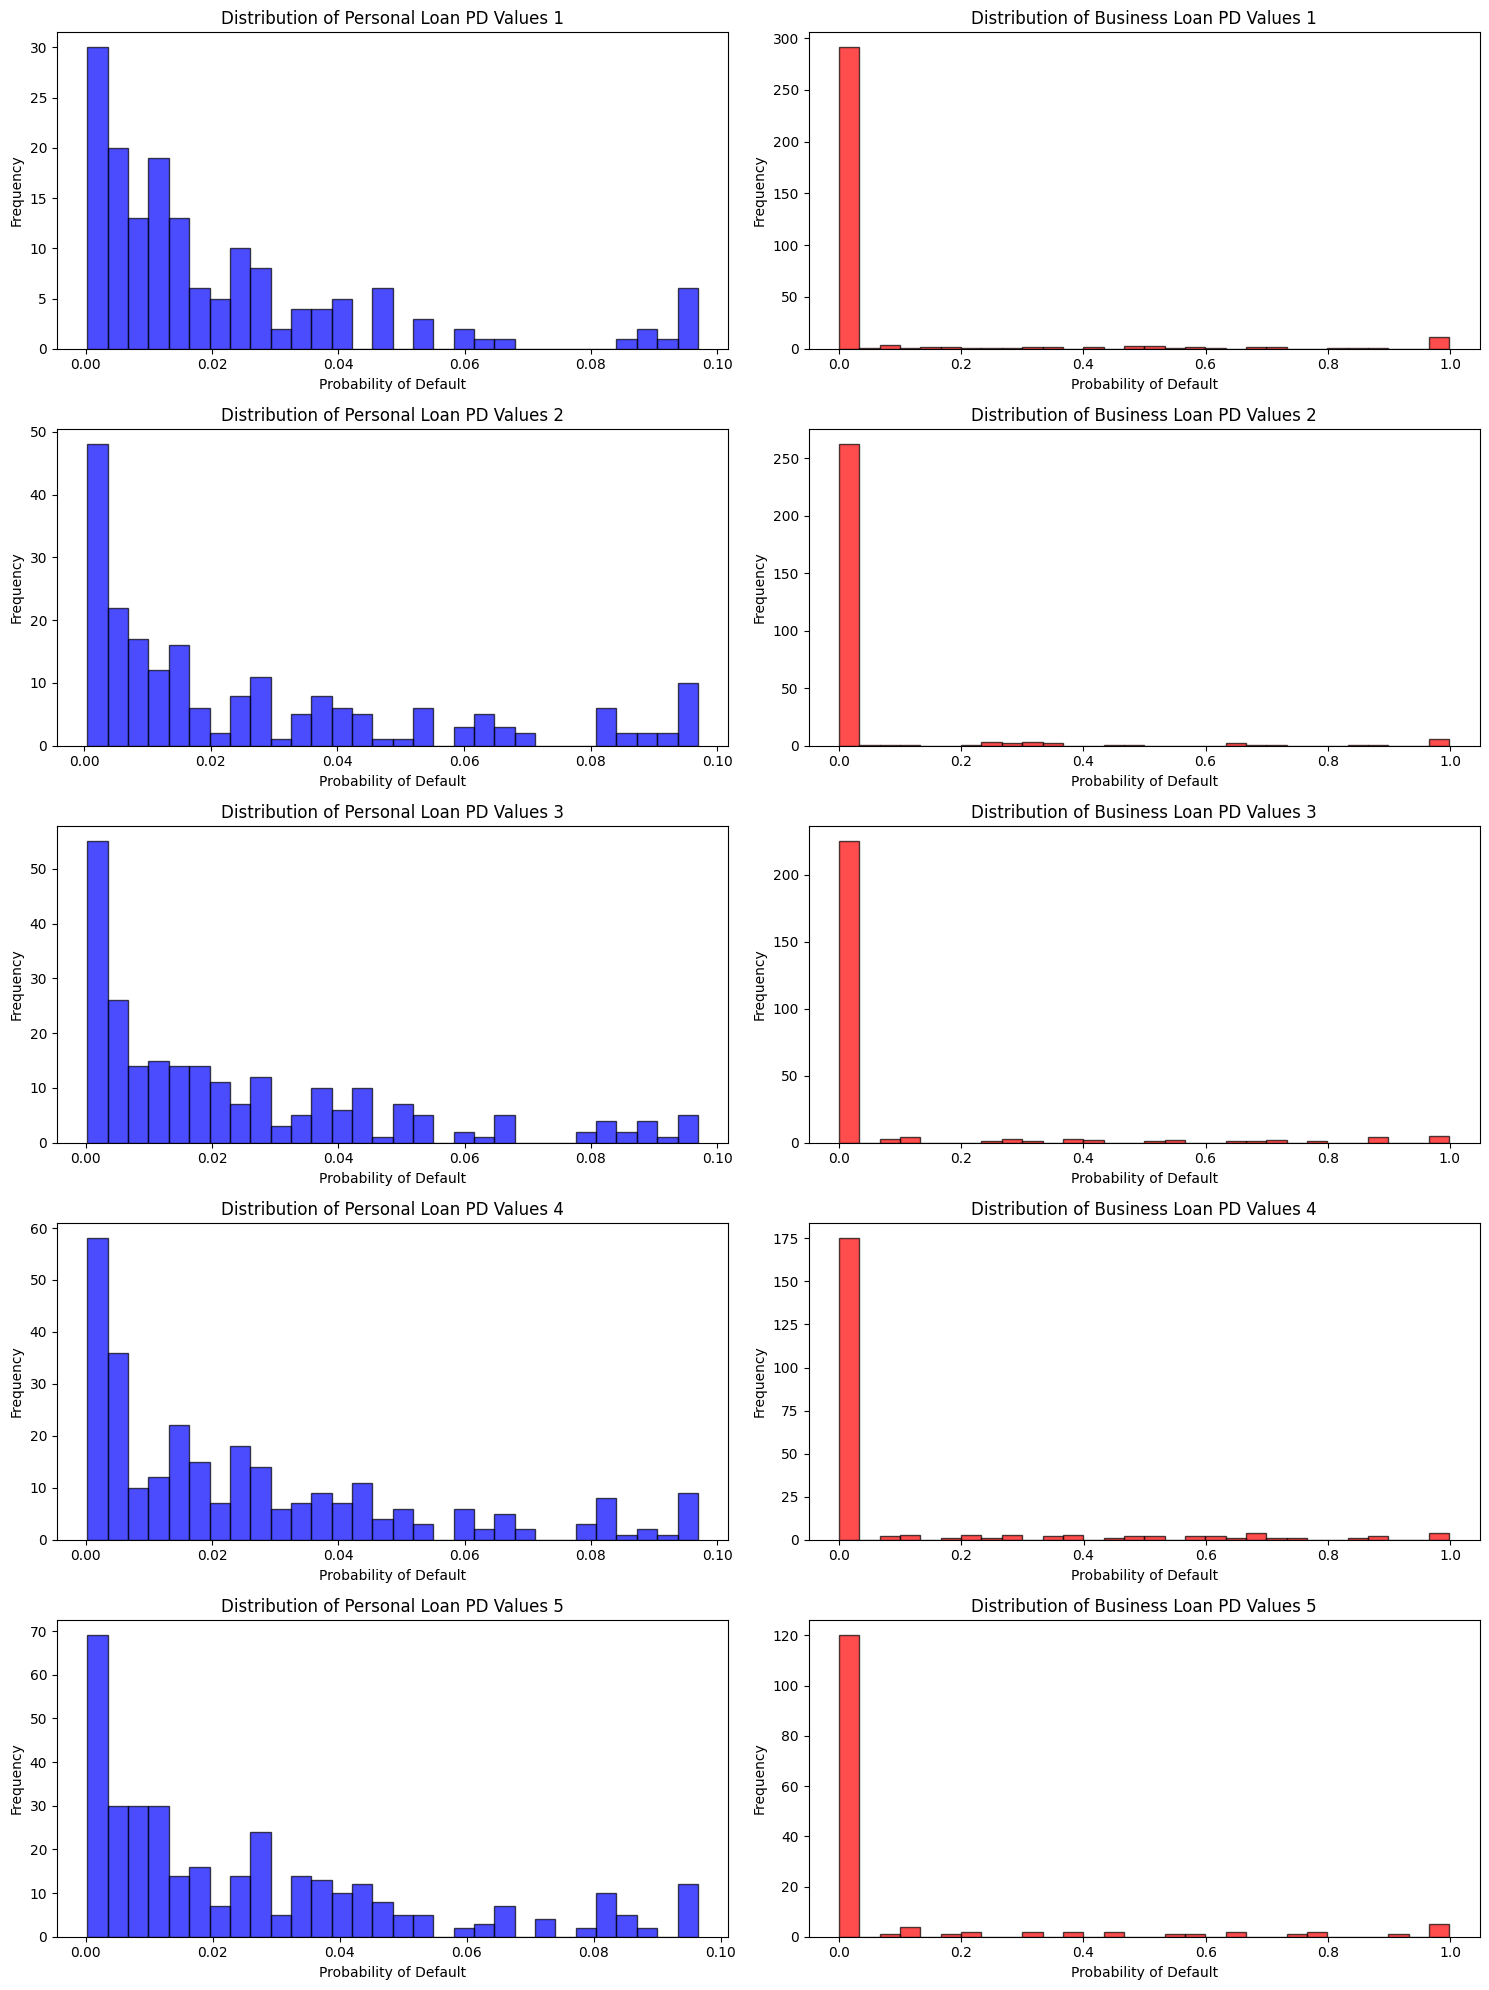

In [21]:
# Data for personal and business PDs (example)
personal_PD = [personal_PD1, personal_PD2, personal_PD3, personal_PD4, personal_PD5]
business_PD = [business_PD1, business_PD2, business_PD3, business_PD4, business_PD5]

# Create a figure and axes for the subplots
fig, axs = plt.subplots(5, 2, figsize=(15, 20))  # 5 rows, 2 columns

# Flatten the 2D array of axes for easier iteration
axs = axs.flatten()

# Iterate through each pair of personal and business PD data
for i in range(len(personal_PD)):
    # Plot personal loan PD distribution
    axs[2*i].hist(personal_PD[i], bins=30, color='blue', alpha=0.7, edgecolor='black')
    axs[2*i].set_title(f'Distribution of Personal Loan PD Values {i+1}')
    axs[2*i].set_xlabel('Probability of Default')
    axs[2*i].set_ylabel('Frequency')

    # Plot business loan PD distribution
    axs[2*i+1].hist(business_PD[i], bins=30, color='red', alpha=0.7, edgecolor='black')
    axs[2*i+1].set_title(f'Distribution of Business Loan PD Values {i+1}')
    axs[2*i+1].set_xlabel('Probability of Default')
    axs[2*i+1].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

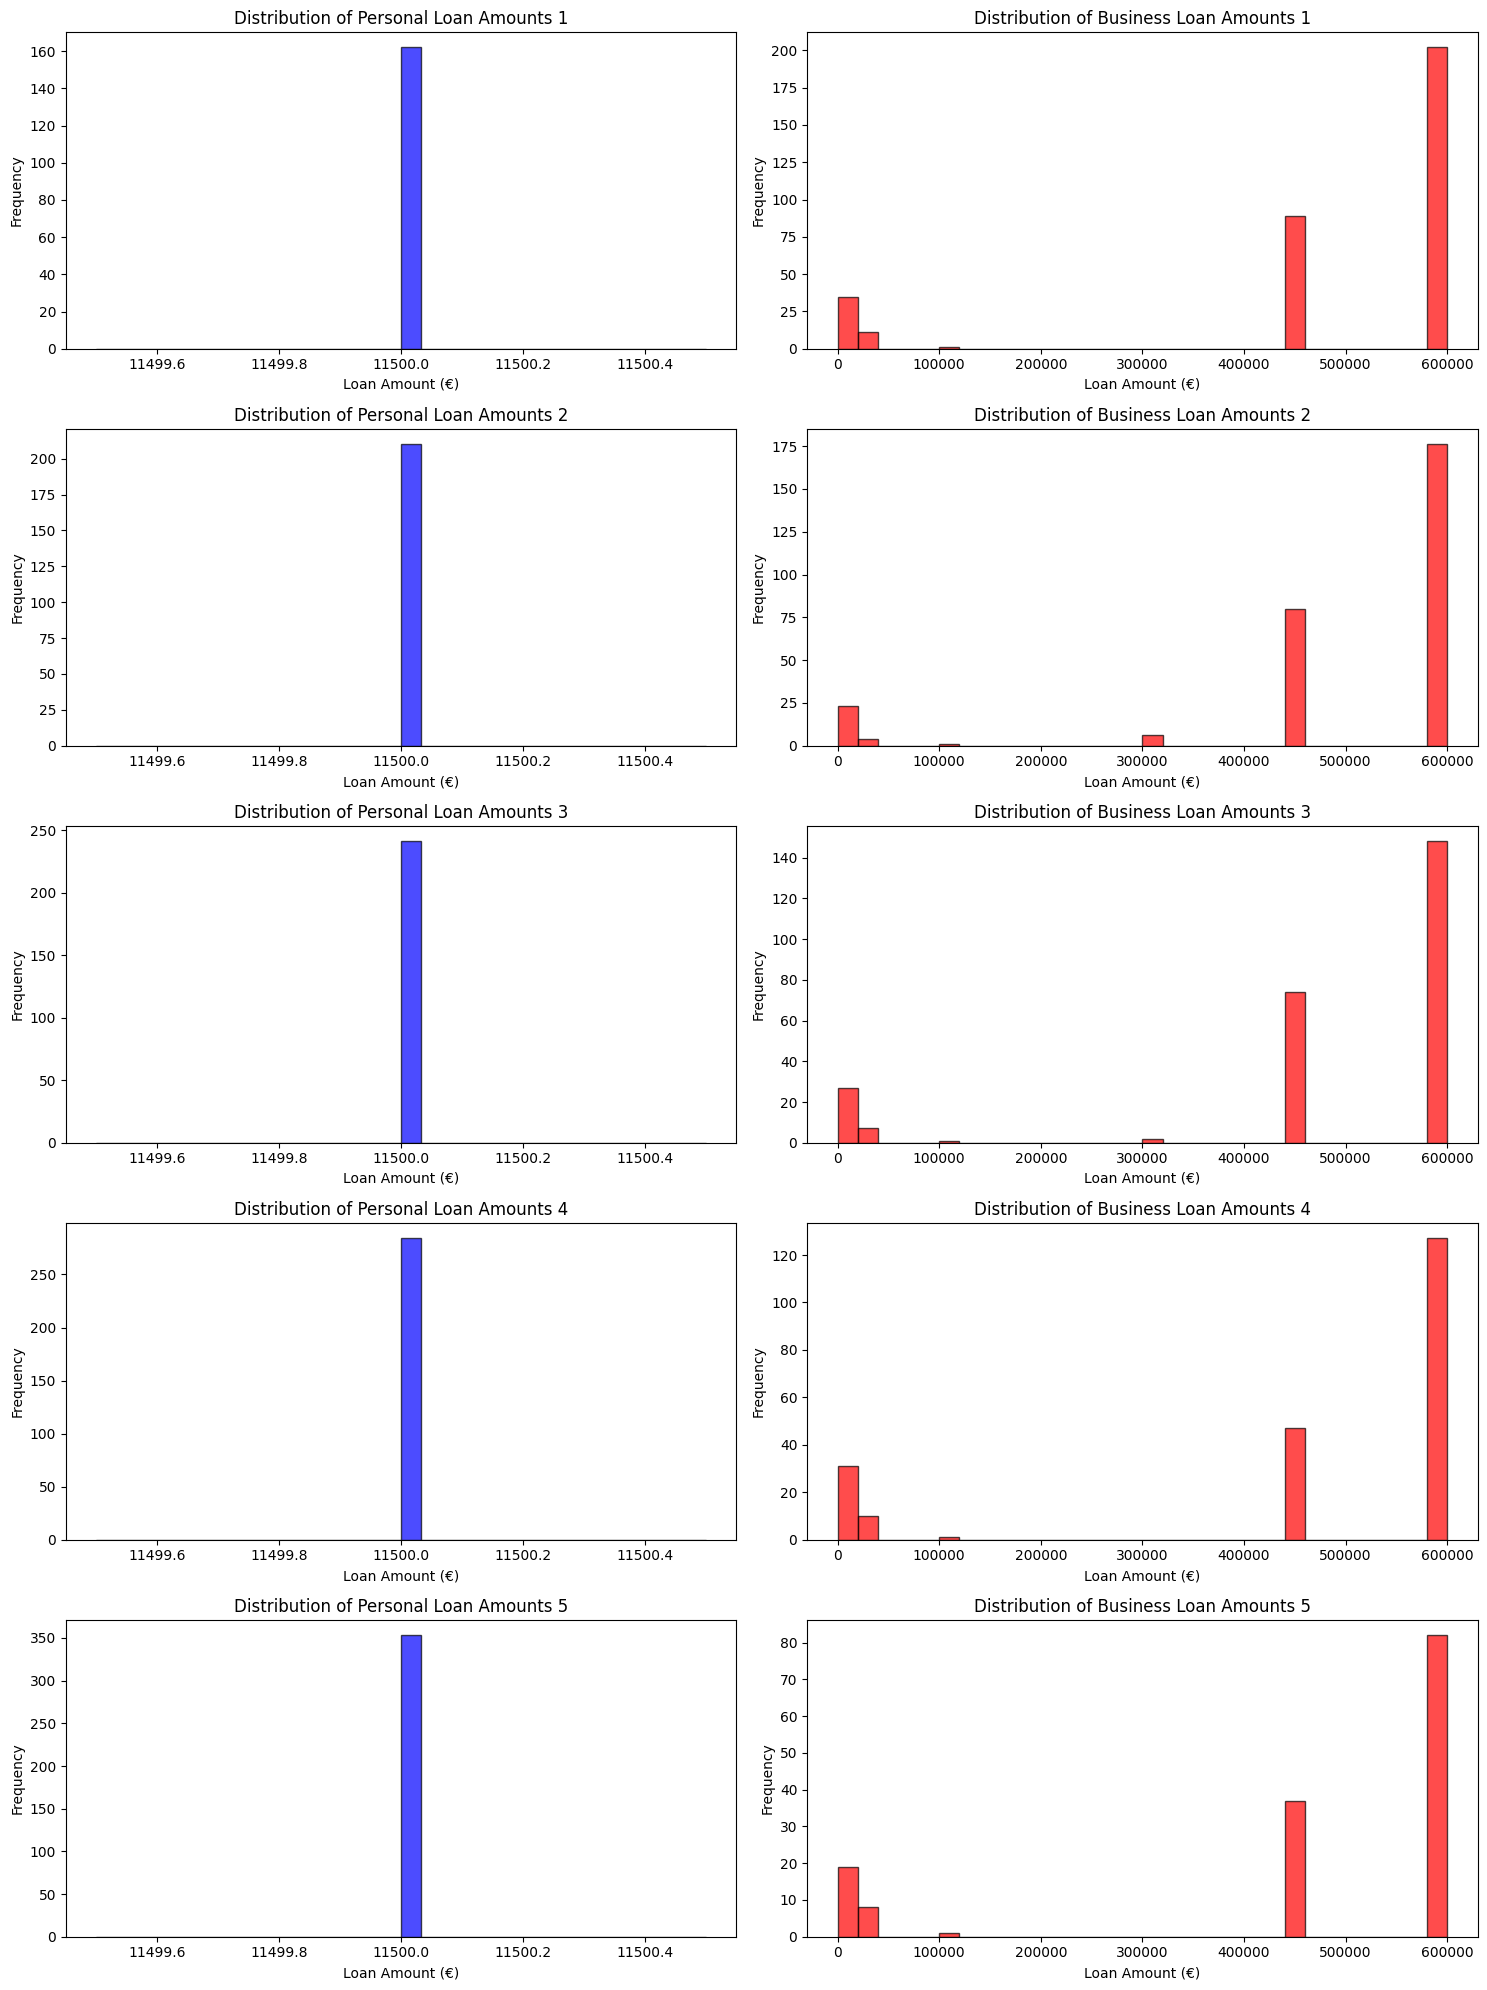

In [23]:
from matplotlib.ticker import ScalarFormatter

# Data for loan amounts (example)
loan_amounts_personal = [loan_amounts_personal1, loan_amounts_personal2, loan_amounts_personal3, loan_amounts_personal4, loan_amounts_personal5]
loan_amounts_business = [loan_amounts_business1, loan_amounts_business2, loan_amounts_business3, loan_amounts_business4, loan_amounts_business5]

# Create a figure and axes for the subplots
fig, axs = plt.subplots(5, 2, figsize=(15, 20))  # 5 rows, 2 columns

# Flatten the 2D array of axes for easier iteration
axs = axs.flatten()

# Iterate through each pair of personal and business loan amounts
for i in range(len(loan_amounts_personal)):
    # Plot personal loan amounts distribution
    axs[2*i].hist(loan_amounts_personal[i], bins=30, color='blue', alpha=0.7, edgecolor='black')
    axs[2*i].set_title(f'Distribution of Personal Loan Amounts {i+1}')
    axs[2*i].set_xlabel('Loan Amount (€)')
    axs[2*i].set_ylabel('Frequency')
    axs[2*i].xaxis.set_major_formatter(ScalarFormatter(useOffset=False))  # Use ScalarFormatter for the x-axis

    # Plot business loan amounts distribution
    axs[2*i+1].hist(loan_amounts_business[i], bins=30, color='red', alpha=0.7, edgecolor='black')
    axs[2*i+1].set_title(f'Distribution of Business Loan Amounts {i+1}')
    axs[2*i+1].set_xlabel('Loan Amount (€)')
    axs[2*i+1].set_ylabel('Frequency')
    axs[2*i+1].xaxis.set_major_formatter(ScalarFormatter(useOffset=False))  # Use ScalarFormatter for the x-axis

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

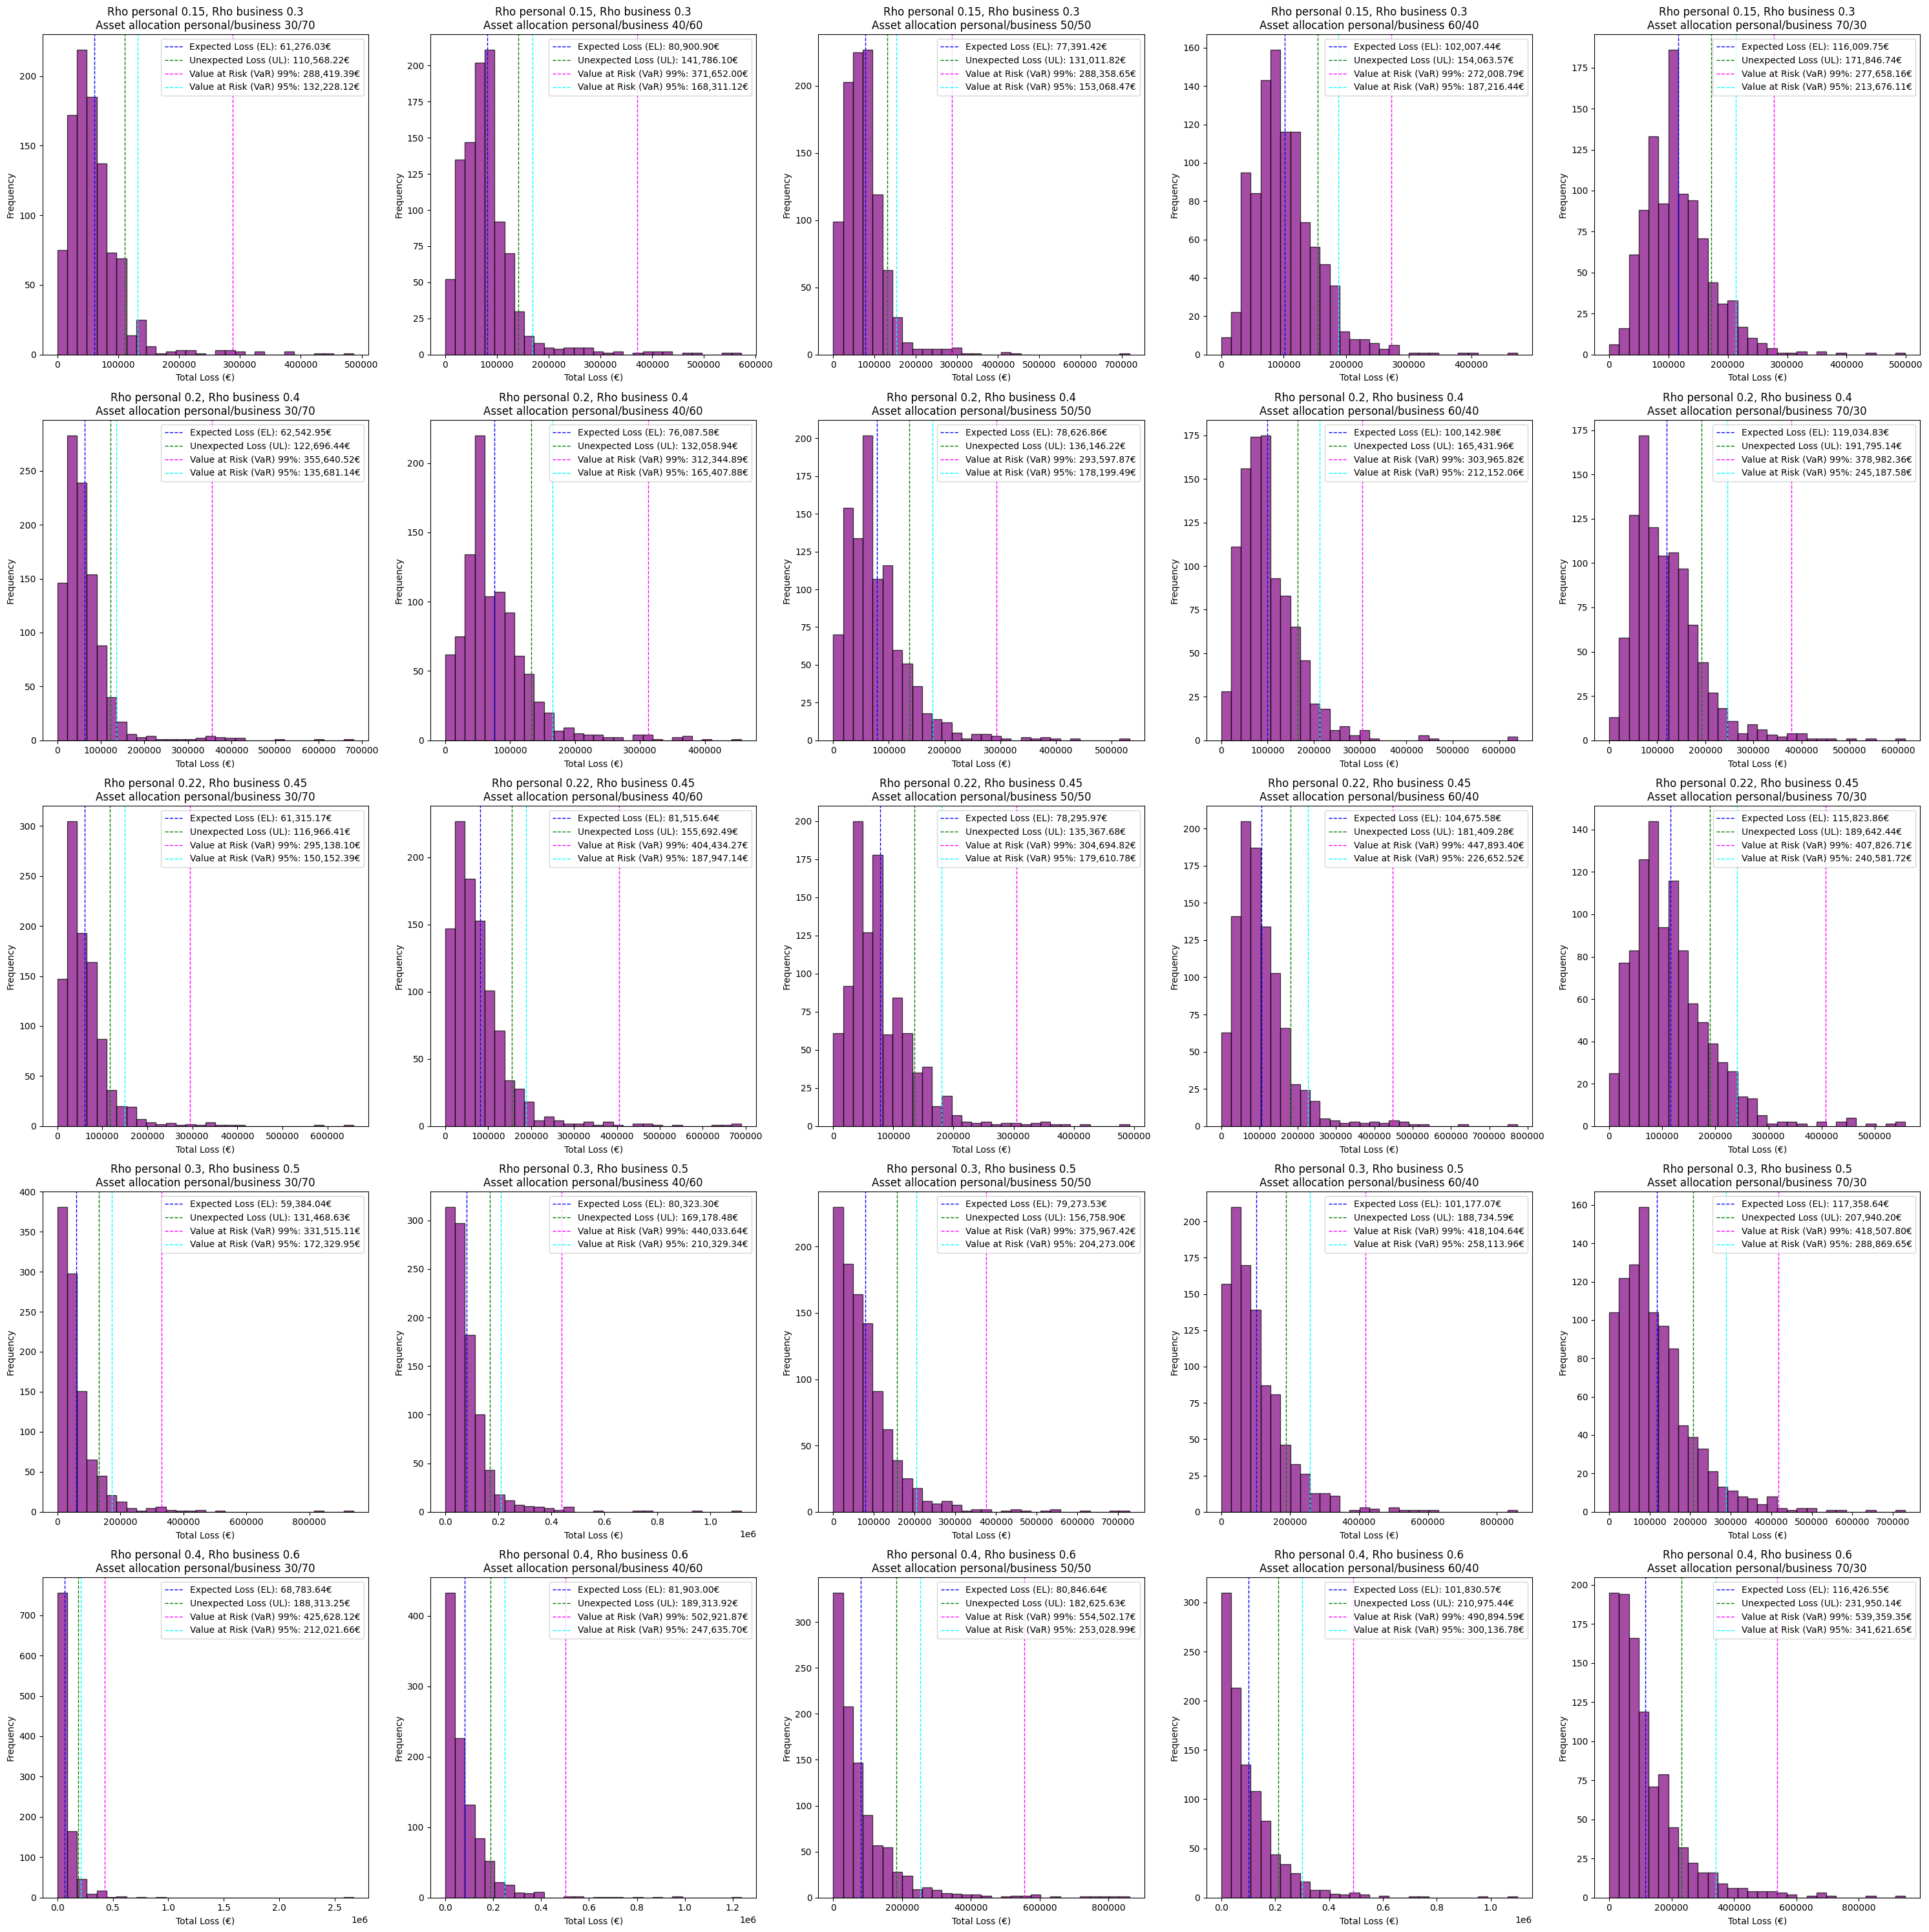

In [53]:
# Define the rho values and loan types for each row
rho_values = [
    (0.15, 0.3),
    (0.2, 0.4),
    (0.22, 0.45),
    (0.3, 0.5),
    (0.4, 0.6)
]

# Define the asset allocations for each column
asset_allocations = [
    (0.3, 0.7),
    (0.4, 0.6),
    (0.5, 0.5),
    (0.6, 0.4),
    (0.7, 0.3)
]

# Create lists of total_losses, points, and colors
total_losses = []
points = []
colors = {
    "Expected Loss (EL)": 'blue',
    "Unexpected Loss (UL)": 'green',
    "Value at Risk (VaR) 99%": 'magenta',
    "Value at Risk (VaR) 95%": 'cyan'
}

# Populate the lists dynamically
for i in range(1, 6):  # Loop for first digit (1 to 5)
    for j in range(1, 6):  # Loop for second digit (1 to 5)
        total_losses.append(eval(f'total_losses{i}{j}'))  # Construct the total_losses variable name dynamically
        points.append({
            "Expected Loss (EL)": eval(f'EL{i}{j}'),
            "Unexpected Loss (UL)": eval(f'UL{i}{j}'),
            "Value at Risk (VaR) 99%": eval(f'VaR_99{i}{j}'),
            "Value at Risk (VaR) 95%": eval(f'VaR_95{i}{j}')
        })

# Create a figure and axes for the subplots
fig, axs = plt.subplots(5, 5, figsize=(30, 30))  # 5 rows, 5 columns

# Flatten the 2D array of axes for easier iteration
axs = axs.flatten()

# Iterate through each set of total losses and points
for k in range(len(total_losses)):
    # Determine rho and loan distribution based on indices i and j
    i = (k // 5)
    j = (k % 5)

    rho_personal, rho_business = rho_values[i]
    personal_allocation, business_allocation = asset_allocations[j]

    # Plot for each total loss distribution
    axs[k].hist(total_losses[k], bins=30, color='purple', alpha=0.7, edgecolor='black')
    axs[k].set_title(
        f'Rho personal {rho_personal}, Rho business {rho_business}\n'
        f'Asset allocation personal/business {int(personal_allocation*100)}/{int(business_allocation*100)}'
    )
    axs[k].set_xlabel('Total Loss (€)')
    axs[k].set_ylabel('Frequency')

    # Add vertical lines for each point
    for label, value in points[k].items():
        axs[k].axvline(x=value, color=colors[label], linestyle='--', linewidth=1, label=f'{label}: {value:,.2f}€')

    # Add legend to each subplot
    axs[k].legend(loc='upper right')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

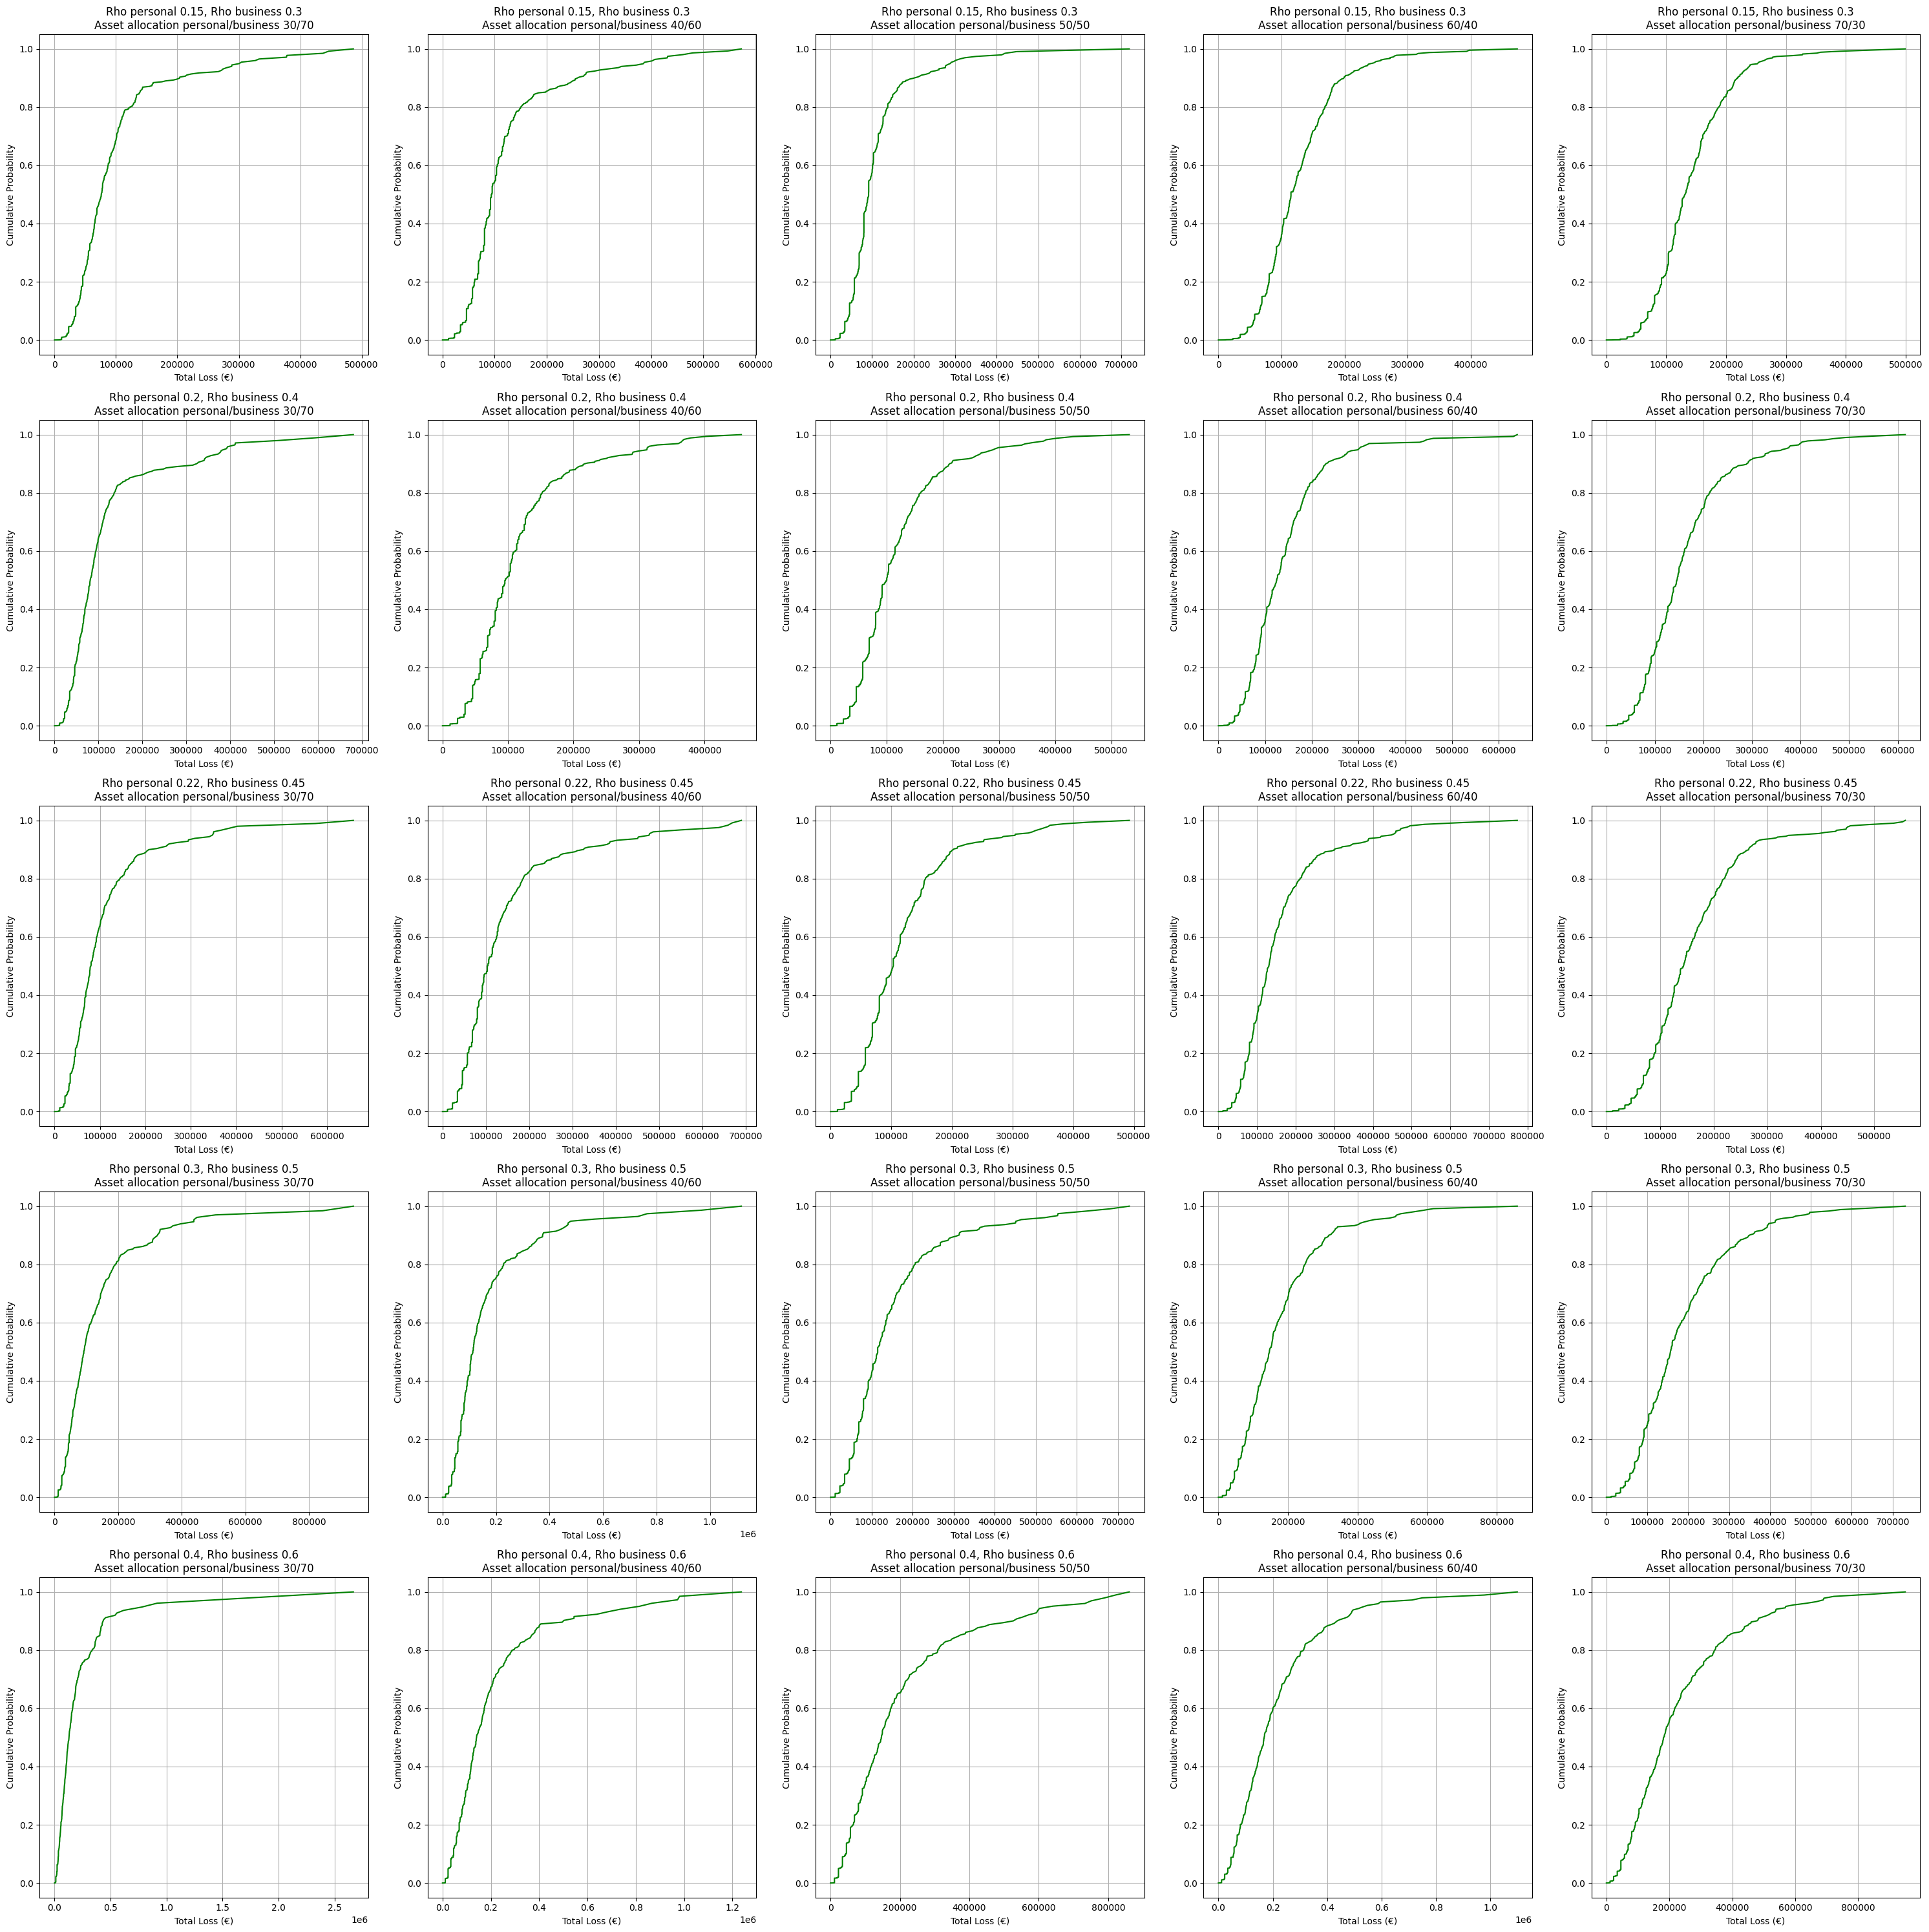

In [79]:
# Create lists of total_losses dynamically
total_losses = []

for i in range(1, 6):  # Loop for first digit (1 to 5)
    for j in range(1, 6):  # Loop for second digit (1 to 5)
        total_losses.append(eval(f'total_losses{i}{j}'))  # Construct the total_losses variable name dynamically

# Create a figure and axes for the subplots
fig, axs = plt.subplots(5, 5, figsize=(30, 30))  # 5 rows, 5 columns

# Flatten the 2D array of axes for easier iteration
axs = axs.flatten()

# Iterate through each set of total losses
for k in range(len(total_losses)):
    # Determine rho and loan distribution based on indices i and j
    i = (k // 5)
    j = (k % 5)

    rho_personal, rho_business = rho_values[i]
    personal_allocation, business_allocation = asset_allocations[j]

    # Sort the losses and compute the cumulative distribution
    sorted_losses = np.sort(total_losses[k])
    cumulative = np.cumsum(sorted_losses) / np.sum(sorted_losses)

    # Plot the cumulative distribution
    axs[k].plot(sorted_losses, cumulative, color='green', label='Cumulative Distribution')

    # Additional plot details
    axs[k].set_title(
        f'Rho personal {rho_personal}, Rho business {rho_business}\n'
        f'Asset allocation personal/business {int(personal_allocation*100)}/{int(business_allocation*100)}'
    )
    axs[k].set_xlabel('Total Loss (€)')
    axs[k].set_ylabel('Cumulative Probability')
    axs[k].grid(True)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()